<a href="https://colab.research.google.com/github/BlackCurrantDS/DBSE_Project/blob/main/E2E_ClusteringApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inputs

In [1]:
Filepath = "/content/"
inputfilepath = "/content/drive/MyDrive/BreastCancer_Dataset1202/breast_train_transactions.txt"
inputTestfilepath = "/content/drive/MyDrive/BreastCancer_Dataset1202/breast_test_transactions.txt"

In [2]:
# for generating rules 
minsup, minconf, itemset_max_size = .01,.8,-1

In [3]:
#paramters for DBSCAN
my_minpts,my_eps = 10, 1
delta1, delta2, substantial_threshold = 0.1, 0.0, 0.0

In [4]:
#for Optics
my_minpoints, xi = 10, .1

Generating Rules

In [5]:
class RuleMiner(object):    
    '''
    This class is used to generate_itemsets_and_rules and store a Naive Belief System 
    by using the most confident association rules
    '''

    def __init__(self, filter_name, train_data_set):
        
        self.nthreads = 4
        self.files_info = ARMFiles(Filepath)
        
        self.filter_name = filter_name
        self.data_set = train_data_set #taking input the dataset


    '''
    Generate association rules and select K patterns with highest confidence.
    '''    
    def generate_itemsets_and_rules(self, arm_params):
        self.generate_frequent_itemsets(arm_params)
        self.generate_association_rules(arm_params)
        #self.extract_features_4_all_rules()

    '''
    Generate frequent itemsets from data-set
    '''
    def generate_frequent_itemsets(self, arm_params):
        
        print ('generating frequent item-sets...')
        apriori = Apriori(self.data_set)
        apriori.generate_frequent_itemsets_vw(arm_params.min_sup * self.data_set.size(), 
                                              self.nthreads, 
                                              arm_params.itemset_max_size, 
                                              self.files_info.itemset_tmp_file)
        
    '''
    Generate association rules from data-set. 
    This method must be called after generate_frequent_itemsets(...) is called
    '''
    def generate_association_rules(self, arm_params):
        freq_itemsets_dict = self.load_frequent_itemsets_as_dict()
        
        print ('generating rules ....')
        itemset_formatter = getattr(ItemsetFormatter, self.filter_name)
        rule_formatter = getattr(RuleFormatter, self.filter_name)
        rule_generator = Generator(freq_itemsets_dict, 
                                   arm_params.min_conf, 
                                   itemset_formatter, 
                                   rule_formatter, 
                                   self.nthreads)
        rule_generator.execute(self.files_info.rules_tmp_file)


    '''
    Load generated frequent itemsets from file. 
    This method must be called after generate_frequent_itemsets is called
    '''
    def load_frequent_itemsets_as_dict(self):
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file(self.files_info.itemset_tmp_file)
        return freq_itemset_dict

In [6]:
class RuleMiner(object):    
    '''
    This class is used to generate_itemsets_and_rules and store a Naive Belief System 
    by using the most confident association rules
    '''

    def __init__(self, filter_name, train_data_set):
        
        self.nthreads = 4
        self.files_info = ARMFiles(Filepath)
        
        self.filter_name = filter_name
        self.data_set = train_data_set #taking input the dataset


    '''
    Generate association rules and select K patterns with highest confidence.
    '''    
    def generate_itemsets_and_rules(self, arm_params):
        self.generate_frequent_itemsets(arm_params)
        self.generate_association_rules(arm_params)
        #self.extract_features_4_all_rules()

    '''
    Generate frequent itemsets from data-set
    '''
    def generate_frequent_itemsets(self, arm_params):
        
        print ('generating frequent item-sets...')
        apriori = Apriori(self.data_set)
        apriori.generate_frequent_itemsets_vw(arm_params.min_sup * self.data_set.size(), 
                                              self.nthreads, 
                                              arm_params.itemset_max_size, 
                                              self.files_info.itemset_tmp_file)
        
    '''
    Generate association rules from data-set. 
    This method must be called after generate_frequent_itemsets(...) is called
    '''
    def generate_association_rules(self, arm_params):
        freq_itemsets_dict = self.load_frequent_itemsets_as_dict()
        
        print ('generating rules ....')
        itemset_formatter = getattr(ItemsetFormatter, self.filter_name)
        rule_formatter = getattr(RuleFormatter, self.filter_name)
        rule_generator = Generator(freq_itemsets_dict, 
                                   arm_params.min_conf, 
                                   itemset_formatter, 
                                   rule_formatter, 
                                   self.nthreads)
        rule_generator.execute(self.files_info.rules_tmp_file)


    '''
    Load generated frequent itemsets from file. 
    This method must be called after generate_frequent_itemsets is called
    '''
    def load_frequent_itemsets_as_dict(self):
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file(self.files_info.itemset_tmp_file)
        return freq_itemset_dict

Helper classes

In [7]:

def string_2_itemset(key):
    if key == '':
        return []
    else: 
        return key.split(',')

def itemset_2_string(itemset):
    return ",".join(itemset)

def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

def get_full_path(prefix, file_name):
    if prefix == '': return file_name
    return prefix + '//' + file_name


In [8]:
import json

class HashItem:
    
    def __init__(self, item):
        self.last_item = item 
        self.tids = []
    
    def add_tid(self, tid):
        self.tids.append(tid)
        
    def add_tids(self, tids):
        self.tids.extend(tids)
    
    def size(self):
        return len(self.tids)
    
    def serialize(self):
        return json.dumps((self.last_item, self.tids))
    
    def deserialize(self, json_string):
        result = json.loads(json_string)
        self.last_item = result[0]
        self.tids = result[1]
        

In [9]:
class HashItemCollection:
    def __init__(self):
        self.train_data = []
    
    def __iter__(self):
        return iter(self.train_data)
    
    def get_item(self, index):
        return self.train_data[index]
    
    def get_items_from(self, index):
        return self.train_data[index : ]
    
    def size(self):
        return len(self.train_data)
    
    def is_contain(self, item):
        for current_item in self.train_data:
            if current_item.last_item == item : 
                return True
        return False
        
    def sort(self):
        self.train_data.sort(key=lambda x: x.last_item, reverse=False)
    
    def add_item(self, hash_item):
        self.train_data.append(hash_item)
        
    def find_item(self, item):
        left = 0
        right = len(self.train_data) - 1
        while (left <= right):
            pivot = int((left + right)/2)
            if self.train_data[pivot].last_item == item: 
                return pivot
            if self.train_data[pivot].last_item < item:
                left = pivot + 1
            else:
                right = pivot - 1 
        return -1
        
    def add_tid(self, item, tid):
        index = self.find_item(item)
        if index == -1:
            hash_item = HashItem(item)
            hash_item.add_tid(tid)
            
            index = len(self.train_data) - 1
            self.train_data.append(hash_item)
            
            while index >= 0:
                if self.train_data[index].last_item > item:
                    self.train_data[index + 1] = self.train_data[index]
                    index -= 1
                else:
                    break
            self.train_data[index + 1] = hash_item        
        else:
            self.train_data[index].add_tid(tid)
    
    def serialize(self):
        temp = []
        for item in self.train_data:
            temp.append(item.serialize())
        return json.dumps(temp)

    def deserialize(self, json_string):
        self.train_data = []
        
        temp = json.loads(json_string)
        for item_string in temp:
            item = HashItem(None)
            item.deserialize(item_string)
            self.train_data.append(item)
        

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

class ItemsetDictionary(object):
    

    def __init__(self, ntransactions = 0):
        self.itemsets = {}
        self.ntransactions = ntransactions
            
    def size(self):
        return len(self.itemsets)
    
    def exists(self, itemset_key):
        return itemset_key in self.itemsets
    
    def add_itemset(self, itemset_key, amount):
        self.itemsets[itemset_key] = amount
        
    def clear(self):
        self.itemsets.clear()
    
    def convert_2_indexes(self):
        k = 0
        dict_items_indexes = {}
        for item_name, _ in self.itemsets.items():
            dict_items_indexes[item_name] = k
            k += 1
        return dict_items_indexes
            
    def get_names(self):
        return self.itemsets.keys()
        
    def get_frequency(self, itemset_key):
        if self.exists(itemset_key):
            return self.itemsets[itemset_key]
        return 0
        
    def getConfidence(self, rule):
        left = self.get_frequency(rule.lhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        if left == 0: return 0
        return both/left
    
    def get_frequency_combo(self, rule):
        left = self.get_frequency(rule.lhs_string())
        right =self.get_frequency(rule.rhs_string())
        both = self.get_frequency(rule.rule_itemset_2_string())
        
        return left, right, both
    
    def get_support(self, itemset_key):     
        return self.get_frequency(itemset_key)/self.ntransactions
       
    def split(self, nchunks):
        itemsets_names = self.itemsets.keys()
        nitemsets = len(itemsets_names)
        
        print ('Number of frequent item-sets: ' + str(nitemsets))
        itemset_chunks = [[] for _ in range(nchunks)]
        size_of_chunk = (int)(nitemsets/nchunks) + 1
                    
        index = 0
        counter = 0
        
        for itemset_key in itemsets_names:
            if counter < size_of_chunk:
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter += 1
            elif counter == size_of_chunk:
                index += 1
                itemset_chunks[index].append(string_2_itemset(itemset_key))
                counter = 1  
                  
        return itemset_chunks
    
    def save_2_file(self, file_name, write_mode = 'a', write_support = False):
        with open(file_name, write_mode) as text_file:
            for key, value in self.itemsets.items():
                t = value
                if write_support == True:
                    t = value/self.ntransactions
                text_file.write(key + ':' + str(t))
                text_file.write('\n')
            
    def load_from_file(self,file_name):
        self.itemsets.clear()
        
        with open(file_name, "r") as text_file:
            self.ntransactions = int(text_file.readline())
            for line in text_file:
                #print (line)
                subStrings = line.split(':')
                itemset_key = subStrings[0].strip()
                frequency = int(subStrings[1].strip())
                
                self.itemsets[itemset_key] = frequency
                
    def _complement_condition(self, r1, r2):
        merged_itemset = merge_itemsets(r1.left_items, 
                                        r2.left_items)
        
        s = self.get_frequency(itemset_2_string(merged_itemset))
        sl = self.get_frequency(r1.lhs_string())
        sr = self.get_frequency(r2.lhs_string())
    
        #if s > 0: return True
        return max(s/sl, s/sr)
     
        
    '''
    Check if two rules are contrary each other based on the matching function
    r1, r2: dictionaries includes {'r': rule, 'f': feature vector}
    contrast_params: contains thresholds, and size of LHS, RHS features 
    '''
    def is_contrast(self, r1, r2, contrast_params):
        
        n = contrast_params.n_lhs_features
        a = cosine_similarity(np.reshape(r1['f'][n:], (1, -1)),
                              np.reshape(r2['f'][n:], (1, -1)))[0,0]
        if a > contrast_params.delta2: return (False, 0, 0)
        
        b = cosine_similarity(np.reshape(r1['f'][:n], (1, -1)), 
                              np.reshape(r2['f'][:n], (1, -1)))[0,0]
        if b <= contrast_params.delta1: return (False, 0, 0)
        
        t = self._complement_condition(r1['r'], r2['r'])
        if t > contrast_params.share_threshold:
            return (True, b, t)
        return (False, 0, 0)
    
    
    def is_inner_contrast(self, group, contrast_params):
        #print('check inner')
        both_condition = self.find_pottential_contrast_locs(group, group, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            if x >= y: continue
            t = self._complement_condition(group['r'][x], group['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False

        
        
    def find_pottential_contrast_locs(self, group1, group2, contrast_params):
        rhs_sim = cosine_similarity(group1['rhs'], group2['rhs']) 
        rhs_condition = (rhs_sim > contrast_params.delta2).astype(int) 
        if np.all(rhs_condition > 0) == True: return None 
    
        
        lhs_sim = cosine_similarity(group1['lhs'], group2['lhs'])
        lhs_condition = (lhs_sim <= contrast_params.delta1).astype(int)
        if np.all(lhs_condition > 0) == True: return None 
        
        locs = np.where(lhs_condition + rhs_condition <= 0)
        return locs 
        
    def is_outer_contrast(self, group1, group2, contrast_params):
        #print('check outer')
        both_condition = self.find_pottential_contrast_locs(group1, group2, contrast_params)
        if both_condition is None: return False 
        
        for i in range(len(both_condition[0])):
            x = both_condition[0][i]
            y = both_condition[1][i]
            t = self._complement_condition(group1['r'][x], group2['r'][y])
            if t > contrast_params.share_threshold: return True 
            
        return False
    

In [11]:
class HashTable:
    def __init__(self):
        self.table = {}
        
    def size(self):
        return len(self.table)
    
    def is_empty(self):
        return len(self.table) == 0;
    
    def is_contain(self, key, last_item):
        return (key in self.table) and (self.table[key].is_contain(last_item))
    
    def get_items(self):
        return self.table.items()
    
    # insert a new key into the table
    def insert_key(self, key):
        self.table[key] = HashItemCollection()
    
    def insert(self, key, value):
        self.table[key] = value
            
    # remove a key from the table
    def remove_item(self, key):
        self.table.pop(key, None)
        
    # insert a new transaction id into a specific item-set
    def add_tid(self, key, item, tid):
        self.table[key].add_tid(item, tid)
        
    # insert a item set and its transaction 
    def add_item(self, key, hash_item):
        self.table[key].add_item(hash_item)
    
    # get all item-set in the hash table
    def generate_itemset_dictionary(self):
        collection = ItemsetDictionary()
        for key, hash_item_collection in self.table.items():
            for hash_item in hash_item_collection:
                new_key = ''
                if key == '': 
                    new_key = hash_item.last_item
                else:
                    new_key = key + ',' + hash_item.last_item
                collection.add_itemset(new_key, hash_item.size())
        return collection
    
    def generate_itemset_dictionary_vw(self, output_file, write_mode):
        count = 0
        file_writer = open(output_file, write_mode)
        for key, hash_item_collection in self.table.items():
            for hash_item in hash_item_collection:
                new_key = ''
                if key == '': 
                    new_key = hash_item.last_item
                else:
                    new_key = key + ',' + hash_item.last_item
                file_writer.write(new_key + ':' + str(hash_item.size()))
                file_writer.write('\n')
                count += 1
                    
        file_writer.close()
        return count
    
    # get number of item-set have same K - 1 first items.
    def count_itemsets(self, key):
        return self.table[key].size()
    
    # get frequent item-set
    def generate_frequent_itemsets(self, minsup):
        L = HashTable()
        for key, hash_item_collection in self.table.items():
            L.insert_key(key)
            for hash_item in hash_item_collection:
                if hash_item.size() >= minsup:
                    L.add_item(key, hash_item)
            if L.count_itemsets(key) == 0:
                L.remove_item(key)
        return L
                 
    def sort(self):
        for hash_item_collection in self.table.values():
            hash_item_collection.sort()

    # this function is used for multi-thread
    def append(self, other_hash_table):
   
        for key, hash_item_collection in other_hash_table.get_items():
            self.table[key] = hash_item_collection

    def clear(self):
        self.table.clear()
        
    def split(self, n):
        number_of_keys = self.size()
        if number_of_keys < n:
            return [self]
        
        number_for_each_part = (int)(number_of_keys/n) + 1
        counter = 0
        sub_hash_tables = []
        sub_hash_table = HashTable()
        
        for key, hash_item_collection in self.get_items():
            if counter < number_for_each_part:
                sub_hash_table.insert(key, hash_item_collection)
            elif counter == number_for_each_part:
                sub_hash_tables.append(sub_hash_table)
                sub_hash_table = HashTable()
                sub_hash_table.insert(key, hash_item_collection)
                counter = 0
            counter += 1
        sub_hash_tables.append(sub_hash_table)
        return sub_hash_tables     
    
    def serialize(self, file_name):
        with open(file_name, "w") as text_file:
            #json.dump(self.table, text_file)
            k = 0
            for key, value in self.table.items():
                if k > 0:
                    text_file.write('\n')
                text_file.write(key)
                text_file.write('\n')
                text_file.write(value.serialize())
                k += 1
            
    def deserialize(self, file_name, reset_table = True):
        if reset_table == True:
            self.table = {}
        with open(file_name, "r") as text_file:
            k = 0
            collection_key = None
            for line in text_file:
                if k % 2 == 0:
                    collection_key = line.strip()
                else:
                    collection = HashItemCollection()
                    collection.deserialize(line.strip())
                    self.table[collection_key] = collection
                k = k + 1

In [12]:
from multiprocessing import Process
from multiprocessing.managers import BaseManager

class Apriori:
    def __init__(self, train_data_set):
        self.tmp_folder = Filepath
        self.freq_itemsets_tmp_file = self.tmp_folder + 'freqitemsets.tmp'
        self.itemsets_tmp_file = self.tmp_folder + 'itemsetscandidates.tmp'
        self.freq_k_item_sets_tmp_file = self.tmp_folder + 'freq_k_itemsets.tmp'
        self.data_set = train_data_set
        self.L1 = None
        
       
        
    
    def generate_L1(self, min_sup):
        C_1 = HashTable()
        itemset_key = ''
        C_1.insert_key(itemset_key)
    
        n = self.data_set.size()
        print ('size of data-set: ' + str(n))
        
        for tid in range(n):
            transaction = self.data_set.get_transaction(tid)
            for item in transaction:
                C_1.add_tid(itemset_key, item, tid)
            
        print ('get frequent item sets with 1 item')
        self.L1 = C_1.generate_frequent_itemsets(min_sup)
      
    @staticmethod
    def generate_Lk(min_sup, L_k1, C_k, k):
        print('generate candidates with ' + str(k) + ' items')
        for key, hash_item_collection in L_k1.get_items():
            for index in range(hash_item_collection.size() - 1):
                
                index_th_item = hash_item_collection.get_item(index)
                new_key = ''
                if key == '':
                    new_key = index_th_item.last_item
                else:
                    new_key = key +',' + index_th_item.last_item
                new_hash_collection = HashItemCollection()
                
                #check if it is infrequent item-set
                for item in hash_item_collection.get_items_from(index + 1):
                    new_item = HashItem(item.last_item)
                    inter_items = set(index_th_item.tids).intersection(item.tids)      
                    if len(inter_items) >= min_sup:  
                        new_item.add_tids(list(inter_items))
                        new_hash_collection.add_item(new_item)
                        
                if new_hash_collection.size() > 0:        
                    C_k.insert(new_key,  new_hash_collection) 

    def generate_frequent_itemsets(self, min_sup, nthreads, end, output_file, write_support = False):
        
        '''
        Step 1: Generate frequent item-sets with 1 item and write to file
        '''
        nTransactions = self.data_set.size()
        with open(output_file, 'w') as text_file:
            text_file.write(str(nTransactions))
            text_file.write('\n')
        
        
        self.generate_L1(min_sup)
        freq_itemsets_dict = self.L1.generate_itemset_dictionary()
        freq_itemsets_dict.ntransactions = nTransactions
        freq_itemsets_dict.save_2_file(output_file, 'a', write_support)
        freq_itemsets_dict.clear()
        
        '''
        Step 2: Generate frequent item-sets with more than 1 item and append to the file
        '''
        k = 2    
        L_k1 = self.L1
        
        while not L_k1.is_empty() and (end == -1 or k <= end):
            
            print('extracting item-sets with ' + str(k) + ' items ....')
            
            '''
            Divide data into many parts and create processes to generate frequent item-sets
            '''
            L_k = HashTable()
            chunks = L_k1.split(nthreads)
            processes = []
            
            C_ks = []
            BaseManager.register("AprioriHash", HashTable)
            manager = BaseManager()
            manager.start()
            C_ks.append(manager.AprioriHash())
            
            index = 0
            for L_k_1_chunk in chunks:
                process_i = Process(target = Apriori.generate_Lk, 
                                    args=(min_sup, L_k_1_chunk,C_ks[index], k))
                processes.append(process_i)
                index += 1
            
            # wait for all thread completes
            for process_i in processes:
                process_i.start()
                process_i.join()
             
            '''
            Merge results which returns from processes
            '''
            for new_C_k in C_ks:
                L_k.append(new_C_k)
            L_k1.clear()
            L_k1 = L_k
    
            '''
            Append frequent item-sets with k items to file
            '''
            freq_itemsets_dict = L_k1.generate_itemset_dictionary()
            
            print ('Writing frequent itemset to file ' + str(freq_itemsets_dict.size()))
            freq_itemsets_dict.ntransactions = nTransactions
            freq_itemsets_dict.save_2_file(output_file, 'a', write_support)
            freq_itemsets_dict.clear()
            
            k += 1
            
        print ('stop at k = ' + str(k))
     
    @staticmethod
    def generate_Lk_vw(min_sup, L_k1, C_k_file, k):
        print('generate candidates with ' + str(k) + ' items')
        file_writer = open(C_k_file, 'w') 
        for key, hash_item_collection in L_k1.get_items():
            for index in range(hash_item_collection.size() - 1):
                
                index_th_item = hash_item_collection.get_item(index)
                new_key = ''
                if key == '':
                    new_key = index_th_item.last_item
                else:
                    new_key = key +',' + index_th_item.last_item
                new_hash_collection = HashItemCollection()
                
                #check if it is infrequent item-set
                for item in hash_item_collection.get_items_from(index + 1):
                    new_item = HashItem(item.last_item)
                    inter_items = set(index_th_item.tids).intersection(item.tids)      
                    if len(inter_items) >= min_sup:  
                        new_item.add_tids(list(inter_items))
                        new_hash_collection.add_item(new_item)
                        
                if new_hash_collection.size() > 0:  
                    file_writer.write(new_key)
                    file_writer.write('\n')
                    file_writer.write(new_hash_collection.serialize())      
                    file_writer.write('\n')
        file_writer.close()

    def generate_frequent_itemsets_vw(self, min_sup, nThreads, end, output_file):
        
        '''
        Step 1: Generate frequent item-sets with 1 item and write to file
        '''
        ntransactions = self.data_set.size()
        with open(output_file, 'w') as text_file:
            text_file.write(str(ntransactions))
            text_file.write('\n')
        
        
        self.generate_L1(min_sup)
        self.L1.generate_itemset_dictionary_vw(output_file, 'a')
        
        '''
        Step 2: Generate frequent item-sets with more than 1 item and append to the file
        '''
        k = 2    
        L_k1 = self.L1
        
        while not L_k1.is_empty() and (end == -1 or k <= end):
            
            print('extracting item-sets with ' + str(k) + ' items ....')
            
            '''
            Divide data into many parts and create processes to generate frequent item-sets
            '''
            chunks = L_k1.split(nThreads)
            L_k1 = None
            processes = []
            
            index = 0
            for L_k_1_chunk in chunks:
                chunk_output_file = self.freq_itemsets_tmp_file +'.'+ str(index)
                process_i = Process(target = Apriori.generate_Lk_vw, 
                                    args=(min_sup, L_k_1_chunk,chunk_output_file, k))
                processes.append(process_i)
                index += 1
            
            # wait for all thread completes
            for process_i in processes:
                process_i.start()
                process_i.join()
             
            '''
            Merge results which returns from processes
            '''
            L_k1 = HashTable()
            for index in range(len(chunks)):
                chunk_input_file = self.freq_itemsets_tmp_file +'.'+ str(index)
                L_k1.deserialize(chunk_input_file, False)
            
            '''
            Append frequent item-sets with k items to file
            '''
            print ('Writing frequent itemset to file....')
            x = L_k1.generate_itemset_dictionary_vw(output_file, 'a')
            print ('#item-sets: ' + str(x))
            k += 1
            
        print ('stop at k = ' + str(k))

    def get_item_interaction_matrix(self):
        self.generate_L1(0)
        items_dict = self.L1.generate_itemset_dictionary()
        items_dict.nTransaction = self.data_set.size()
        
        nItems = items_dict.size()
        dict_item_indexes = items_dict.convert_2_indexes()
            
        A = np.zeros((nItems, nItems))
        for transaction in self.data_set:
            indexes = []
            for item_name in transaction:
                indexes.append(dict_item_indexes[item_name])
            for i in range(len(indexes)):
                for j in range(i+1, len(indexes)):
                    A[indexes[i], indexes[j]] += 1
                    A[indexes[j], indexes[i]] += 1
        return dict_item_indexes, A
    
        
        

In [13]:
class ItemsetFormatter(object):
   
    @staticmethod
    def mydefault(itemset):
        return True
    
    @staticmethod
    def mass(itemset):
        for item in itemset:
            if item.isdigit() == False:
                return True
        return False
    
    @staticmethod
    def tcr(itemset):
        for item in itemset:
            if item == 'CD4' or item == 'CD8':
                return True
        return False
    
    @staticmethod
    def rna(itemset):
        for item in itemset:
            if 'rna_' in item:
                return True
        return False
        
    @staticmethod
    def ank3(itemset):
        for item in itemset:
            if item == 'CASE' or item == 'HEALTHY':
                return True
        return False
    
    @staticmethod
    def spect(itemset):
        for item in itemset:
            if 'class@' in item:
                return True
        return False
    
    @staticmethod
    def kdd(itemset):
        for item in itemset:
            if 'c_' in item:
                return True
        return False
    
    @staticmethod
    def tcrm(itemset):
        a_count = 0
        b_count = 0
        for item in itemset:
            if 'b_' in item:
                b_count += 1
            if 'a_' in item:
                a_count += 1
        return (a_count > 0 and b_count > 0)

    @staticmethod
    def ppi(itemset):
        a_count = 0
        b_count = 0
        for item in itemset:
            if 'h@' in item:
                b_count += 1
            if 'v@' in item:
                a_count += 1
        return (a_count > 0 and b_count > 0)

    @staticmethod
    def splice(itemset):
        for item in itemset:
            if item == 'EI' or item == 'IE' or item == 'N@':
                return True
        return False

In [14]:
class RuleFormatter(object):
    
    @staticmethod
    def mydefaultLeft(item):
        return True
    
    @staticmethod
    def mydefaultRight(item):
        return True
    
    @staticmethod
    def mydefault(rule):
        #return True
        return len(rule.right_items) == 1#<= 2
    
    
    @staticmethod
    def massLeft(item):
        return item.isdigit()
    
    @staticmethod
    def massRight(item):
        return not item.isdigit()
    
    @staticmethod
    def mass(rule):
        return rule.lhs_string().isdigit() and (not rule.rhs_string().isdigit())
    
    @staticmethod
    def rna(rule):
        condition = (len(rule.right_items) == 1)
        condition &= ('rna_' in rule.rhs_string())
        condition &=  ('rna_' not in rule.lhs_string())
        return condition
    
    @staticmethod
    def tcrLeft(item):
        return item != 'CD4' and item != 'CD8'
    
    @staticmethod
    def tcrRight(item):
        return item == 'CD4' or item == 'CD8'    
    
    @staticmethod
    def tcr(rule):
        left_key = rule.lhs_string()
        right_key = rule.rhs_string()
        return ('CD4' not in left_key) and ('CD8' not in left_key) and (right_key == 'CD4' or right_key == 'CD8')
    
    @staticmethod
    def ank3Left(item):
        return item != 'CASE' and item != 'HEALTHY'
    
    @staticmethod
    def ank3Right(item):
        return item == 'CASE' or item == 'HEALTHY'
        
    @staticmethod
    def ank3(rule):
        left_key = rule.lhs_string()
        right_key = rule.rhs_string()
        return ('CASE' not in left_key) and ('HEALTHY' not in left_key) and (right_key == 'CASE' or right_key == 'HEALTHY')
    
    @staticmethod
    def spectLeft(item):
        return 'class@' not in item
    
    @staticmethod
    def spectRight(item):
        return 'class@' in item
        
    @staticmethod
    def spect(rule):
        flag = True
        for item in rule.right_items:
            if 'class@' not in item:
                flag = False
                break
        left_key = rule.lhs_string()
        return ('class@' not in left_key) and flag == True
    
    @staticmethod
    def kddLeft(item):
        return ('c_' in item) == False
    
    @staticmethod
    def kddRight(item):
        return 'c_' in item
        
    @staticmethod
    def kdd(rule):
        left_key = rule.lhs_string()
        right_key = rule.rhs_string()
        return ('c_' not in left_key) and (len(rule.right_items) == 1 and 'c_' in right_key)
    
    @staticmethod
    def tcrmLeft(item):
        return True
    
    @staticmethod
    def tcrmRight(item):
        return True
        
    @staticmethod
    def tcrm(rule):
        a_count1 = 0
        b_count1 = 0
        for item in rule.left_items:
            if 'b_' in item:
                b_count1 += 1
            if 'a_' in item:
                a_count1 += 1
        if a_count1 > 0 and b_count1 > 0: return False
        
        a_count2 = 0
        b_count2 = 0
        for item in rule.right_items:
            if 'b_' in item:
                b_count2 += 1
            if 'a_' in item:
                a_count2 += 1
        if a_count2 > 0 and b_count2 > 0: return False
        
        return (a_count1 > 0 and b_count2 > 0) or (b_count1 > 0 and a_count2 > 0)
    
    @staticmethod
    def ppiLeft(item):
        return True
    
    @staticmethod
    def ppiRight(item):
        return True
        
    @staticmethod
    def ppi(rule):
        a_count1 = 0
        b_count1 = 0
        for item in rule.left_items:
            if 'h@' in item:
                b_count1 += 1
            if 'v@' in item:
                a_count1 += 1
        if a_count1 > 0 and b_count1 > 0: return False
        
        a_count2 = 0
        b_count2 = 0
        for item in rule.right_items:
            if 'h@' in item:
                b_count2 += 1
            if 'v@' in item:
                a_count2 += 1
        if a_count2 > 0 and b_count2 > 0: return False
        
        return (a_count1 > 0 and b_count2 > 0) or (b_count1 > 0 and a_count2 > 0)
    
    
    @staticmethod
    def spliceLeft(item):
        return item != 'EI' and item != 'IE' and item != 'N@'
    
    @staticmethod
    def spliceRight(item):
        return item == 'D_0' or item == 'D_1' or item == 'N@'
        
    @staticmethod
    def splice(rule):
        left_key = rule.lhs_string()
        right_key = rule.rhs_string()
        return ('EI' not in left_key) and ('IE' not in left_key) and ('N@' not in left_key) and (right_key == 'EI' or right_key == 'IE' or right_key == 'N@')
        

In [15]:
class AssociationRule:
    def __init__(self, left, right):
        self.left_items = left
        self.right_items = right
        self.scores = []
        
    def length(self):
        return len(self.left_items) + len(self.right_items)
     
    def score(self, index):
        return self.scores[index]
    
    def lhs_string(self):
        return itemset_2_string(self.left_items)
        
    def rhs_string(self):
        return itemset_2_string(self.right_items)
    
    def serialize(self):
        left_key = self.lhs_string()
        right_key = self.rhs_string()
        return left_key + ">" + right_key
    
    @staticmethod        
    def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        #print("AssociationRule(left, right",AssociationRule(left, right))
        return AssociationRule(left, right)

    def append_score(self, score):
        self.scores.append(score)
        
    def get_itemset(self):
        itemset = []
        itemset.extend(self.left_items)
        itemset.extend(self.right_items)
        itemset.sort()
        return itemset
        
        
    def rule_itemset_2_string(self):
        itemset = self.get_itemset()
        return itemset_2_string(itemset)
    
    def compute_basic_probs(self,frequent_itemsets, nTransactions):  
        
        left = frequent_itemsets[self.lhs_string()]
        right = frequent_itemsets[self.rhs_string()]
        
        both = frequent_itemsets[self.rule_itemset_2_string()]
        
        vector = {}
        
        ''' 1. P(A)'''
        p_A = left/nTransactions
        vector['A'] = p_A
        
        ''' 2. P(B)'''
        p_B = right/nTransactions
        vector['B'] = p_B
        
        ''' 3. P(~A)'''
        p_not_A = 1 - p_A
        vector['~A'] = p_not_A
        
        ''' 4. P(~B)'''
        p_not_B = 1 - p_B
        vector['~B'] = p_not_B
        
        ''' 5. P(AB) '''
        p_A_and_B = both/nTransactions
        vector['AB'] = p_A_and_B
        
        ''' 6. P(~AB)'''
        p_not_A_and_B = (right - both)/nTransactions
        vector['~AB'] = p_not_A_and_B
        
        ''' 7. P(A~B)'''
        p_A_and_not_B = (left - both)/nTransactions
        vector['A~B'] = p_A_and_not_B
        
        ''' 8. P(~A~B)'''
        p_not_A_and_not_B = 1 - (left + right - both)/nTransactions
        vector['~A~B'] = p_not_A_and_not_B 
        
        '''
        9. P(A|B)
        '''
        p_A_if_B = p_A_and_B / p_B
        vector['A|B'] = p_A_if_B
        
        '''
        10. P(~A|~B)
        '''
        p_not_A_if_not_B = p_not_A_and_not_B / p_not_B
        vector['~A|~B'] = p_not_A_if_not_B
        
        '''
        11. P(A|~B)
        '''
        p_A_if_not_B = p_A_and_not_B/p_not_B
        vector['A|~B'] = p_A_if_not_B
        
        '''
        12. p(~A|B)
        '''
        p_not_A_if_B = p_not_A_and_B / p_B
        vector['~A|B'] = p_not_A_if_B
        
        '''
        13. P(B|A)
        '''
        p_B_if_A = p_A_and_B / p_A
        vector['B|A'] = p_B_if_A
        
        '''
        14. P(~B|~A)
        '''
        p_not_B_if_not_A = p_not_A_and_not_B / p_not_A
        vector['~B|~A'] = p_not_B_if_not_A
        
        '''
        15. P(B|~A)
        '''
        p_B_if_not_A = p_not_A_and_B/p_not_A
        vector['B|~A'] = p_B_if_not_A
        
        '''
        16. p(~B|A)
        '''
        p_not_B_if_A = p_A_and_not_B / p_A
        vector['~B|A'] = p_not_B_if_A
        
        return vector
    
    def is_redundant_(self, bits, k, itemset, freq_itemset_dict): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(itemset):
            items_1 = []
            items_2 = []
            for index in range(len(bits)):
                if bits[index] == True:
                    items_1.append(itemset[index])
                else:
                    items_2.append(itemset[index])
            for item in items_2:
                rule = AssociationRule(items_1, [item])
                confidence = freq_itemset_dict.getConfidence(rule)
                if confidence == 1: return True
            return False 
      
        value_domain = [True, False]
        for value in value_domain:
            bits[k] = value
            checker = self.is_redundant_(bits, k+1, itemset, freq_itemset_dict)
            if checker == True: return True
            bits[k] = True    
        return False
    
    '''
    Expand an item-set with equivalent items.
    '''
    def is_redundant(self, freq_itemset_dict):
        bits = [True for _ in self.left_items]
        checker = self.is_redundant_(bits, 0, self.left_items, freq_itemset_dict)
        if checker == True: return True
        
        bits =  [True for _ in self.right_items]
        return self.is_redundant_(bits, 0, self.right_items, freq_itemset_dict)
    
    '''
    Check if an item-set is satisfied condition of the rule. 
    '''
    def satisfy_rule(self, itemset, is_lhs = True):
        condition = self.left_items
        if is_lhs == False: condition = self.right_items
        if len(condition) > len(itemset) or len(itemset) == 0:
            return False
        for item in condition:
            if item not in itemset:
                return False
        return True
    

In [16]:
class RulesCollection(object):

    def __init__(self):
        self.rules = []
        
        
    def size(self):
        return len(self.rules)
        
    def add(self, r):
        self.rules.append(r)
        
    def clear(self):
        self.rules.clear()
        
    def save(self, file_name, is_append):
        mode = 'w'
        if is_append == True:
            mode = 'a'
        with open(file_name, mode) as text_file:
            for rule in self.rules:
                text_file.write(rule.serialize())
                text_file.write('\n')
                
    def load_from_file(self, file_name):    
        with open(file_name, "r") as text_file:
            for line in text_file:
                rule = AssociationRule.string_2_rule(line)
                self.rules.append(rule)
        
    def remove_redundancy(self, freq_itemset_dict):
        new_rules = []
        for r in self.rules:
            if r.is_redundant(freq_itemset_dict):
                continue
            new_rules.append(r)
        self.rules = new_rules 
                
class RulesDictionary():
    
    def __init__(self):
        self.rules = {}
                    
    def load_from_file(self, file_name):
        with open(file_name, "r") as text_file:
            for line in text_file:
                rule = AssociationRule.string_2_rule(line)
                self.rules[line.strip()] = rule
    
    def get_rules(self):
        return list(self.rules.values())
    
    def rule_2_string(self):
        return list(self.rules.keys())
    
    def clear(self):
        self.rules.clear()

In [17]:
class Generator:
    
    def __init__(self, freq_itemset_dict, 
                 min_conf, 
                 itemset_formatter, 
                 rule_formatter, 
                 nThreads):
        self.itemset_formatter = itemset_formatter
        self.rule_formatter = rule_formatter
        
        self.nthreads = nThreads
        self.freq_itemset_dict = freq_itemset_dict
        
        self.min_conf = min_conf
    
    @staticmethod
    def string_2_rule_and_support(s):
        subStrings = s.split('#')
        rule  = Generator.string_2_rule(subStrings[0].strip())
        v = json.loads(subStrings[1].strip())
        return rule, v
    
    @staticmethod
    def rule_and_support_2_string(rule, p):
        return rule.serialize() + '#' + json.dumps(p)
                
    '''
    Generate association rules for one item-set
    '''
    def subsets(self, bits, item_set, k, rule_collection, total_freq): 
        '''
        Run out of items --> create rule and check format criterion
        '''
        if k >= len(item_set):
            left = []
            right = []
                    
            for index in range(len(bits)):
                if bits[index] == True:
                    left.append(item_set[index])
                else:
                    right.append(item_set[index])
                                      
            if (len(left) > 0 and len(right) > 0):
                rule = AssociationRule(left, right)
                if (self.rule_formatter == None or self.rule_formatter(rule) == True):
                    rule_collection.add(rule)
            
            return 
      
        value_domain = [True, False]
        '''
        Include k-th item into LHS 
        '''
        
        for value in value_domain:
            bits[k] = value
               
            if (value == False):
                left_itemset = []
                for index in range(len(bits)):
                    if bits[index] == True:
                        left_itemset.append(item_set[index])
                        
                left_value = self.freq_itemset_dict.get_frequency(itemset_2_string(left_itemset))
                confident = 0
                if left_value > 0: confident = total_freq/left_value
                
                if confident < self.min_conf:
                    bits[k] = True
                    continue
                self.subsets(bits, item_set, k+1, rule_collection, total_freq)
            else:
                self.subsets(bits, item_set, k+1, rule_collection, total_freq)
                
            bits[k] = True
    '''
    Generate association rules for a set of item-sets and write results to a file
    '''
    def generate_rules(self, freq_itemsets_collection, output_file_name):
        total_rules = 0
        remaining_rules = 0
        k = 0
        rule_collection = RulesCollection()
        with open(output_file_name, 'w') as _:
            print ('clear old file...')
            
        for itemset in freq_itemsets_collection:
            '''
            Check item-set first if it can generate a rule
            '''
            if len(itemset) == 1:
                continue
     
         
            if self.itemset_formatter is not None and \
            self.itemset_formatter(itemset) == False:
                continue
            
            '''
            Write generated rule_collection into file
            '''
            k += 1
            if k % 200 == 0:
                print ('writing some rule_collection to file: ' + str(k))
                total_rules += rule_collection.size()
                rule_collection.remove_redundancy(self.freq_itemset_dict)
                rule_collection.save(output_file_name, True)
                remaining_rules += rule_collection.size()
                rule_collection.clear()
            
            '''
            Generating association rule_collection.
            '''
            total_freq = self.freq_itemset_dict.get_frequency(itemset_2_string(itemset))
            bits = [True] * len(itemset)
            self.subsets(bits, itemset, 0, rule_collection, total_freq)
                    
        print ('writing last rule_collection to file: ' + str(k))
        total_rules += rule_collection.size()
        rule_collection.remove_redundancy(self.freq_itemset_dict)
        rule_collection.save(output_file_name, True)
        remaining_rules += rule_collection.size()
        rule_collection.clear()
        
        print ('Finish for sub frequent item-sets!!!')
        print ('Number of redundant rules ' + str(total_rules - remaining_rules) + '/' + str(total_rules))
                  
    '''
    Generate association rules for whole data-set
    '''  
    def execute(self, output_file_name):
        
        itemset_chunks = self.freq_itemset_dict.split(self.nthreads)
        
        processes = []
        for index in range(self.nthreads):
            file_name = output_file_name + '.' + str(index)
            process_i = Process(target=self.generate_rules, 
                                args=(itemset_chunks[index], file_name))
            processes.append(process_i)
            
            
        for process_i in processes:
            process_i.start()
            
        # wait for all thread completes
        for process_i in processes:
            process_i.join()
            
        print ('Finish generating rules!!!!')    
            
            

Argumetns

In [18]:
class ARMParams(object):
    '''
    classdocs
    '''

    def __init__(self, minsup, minconf, itemset_max_size=-1):
        '''
        Constructor
        '''
        self.min_sup = minsup 
        self.min_conf = minconf
        self.itemset_max_size = itemset_max_size

In [19]:
class ARMFiles(object):
    '''
    classdocs
    '''

    def __init__(self, default_folder = Filepath):
        '''
        Constructor
        '''
        self.temp_folder = default_folder
        
        self.itemset_tmp_file = self.temp_folder + 'miner.tmp.itemsets'
        self.rules_tmp_file = self.temp_folder + 'miner.tmp.rules'
        self.best_rules_file = self.temp_folder + 'miner.best_tmp.rules'
        
        self.interestingness_tmp_file = self.temp_folder +'miner.tmp.interestingness'
        self.probabilities_tmp_file = self.temp_folder +'miner.tmp.probabilities'
        
        self.feature_tmp_file = self.temp_folder +'miner.tmp.features'
        self.non_redundant_rule_tmp_file = self.temp_folder +'miner.tmp.non_redundant_rules'
        self.non_redundant_rule_feature_tmp_file = self.temp_folder + 'miner.tmp.non_redundant_rules.features'
        self.relation_tmp_file = self.temp_folder + 'relation_matrix.csv'
        
    def get_rule_file(self, i):
        return self.rules_tmp_file + '.' + str(i)

getting data

In [20]:
class DataSet:
    def __init__(self):
        self.current = 0
        self.train_data = []
        self.data_labels = []
        
    
    def __iter__(self):
        return iter(self.train_data)
                
    def size(self):
        return len(self.train_data)
    
    def get_transaction(self, index):
        return self.train_data[index]
    
    def clear(self):
        self.train_data.clear()
        
    def add_transaction(self, t):
        return self.train_data.append(t)

    '''
    Load data set from a file. The input file must be formated in CSV (comma separated)
    class_index is used in the case of data-set with labels. 
    '''
    def load(self, Filepath, class_index = -1, has_header = False):
        self.train_data = []
        if class_index != -1: self.data_labels = []
        
        with open(Filepath, "r") as text_in_file:
            if has_header == True:
                text_in_file.readline()
                
            for line in text_in_file:
                #print("dataset script line", line)
                transaction = [x.strip() for x in line.split(',')]
                transaction = list(filter(None, transaction))
                #print("datset script transaction" , transaction)
                
                if (class_index != -1):
                    self.data_labels.append(transaction[class_index])
                    del transaction[class_index]
                
                self.train_data.append(list(set(transaction)))
        print("Loading done")

Getting data as input

In [21]:
train_data_set = DataSet()

In [22]:
train_data_set.load(inputfilepath, -1)

Loading done


In [23]:
rule_miner = RuleMiner('spect', train_data_set)

Give arguments

In [24]:
arm_params = ARMParams(minsup, minconf, itemset_max_size)

Generates frequent item sets and rules

In [25]:
rule_miner.generate_itemsets_and_rules(arm_params)

generating frequent item-sets...
size of data-set: 240
get frequent item sets with 1 item
extracting item-sets with 2 items ....
generate candidates with 2 items
Writing frequent itemset to file....
#item-sets: 467
extracting item-sets with 3 items ....
generate candidates with 3 items
generate candidates with 3 items
generate candidates with 3 items
generate candidates with 3 items
Writing frequent itemset to file....
#item-sets: 2257
extracting item-sets with 4 items ....
generate candidates with 4 items
generate candidates with 4 items
generate candidates with 4 items
generate candidates with 4 items
Writing frequent itemset to file....
#item-sets: 5225
extracting item-sets with 5 items ....
generate candidates with 5 items
generate candidates with 5 items
generate candidates with 5 items
generate candidates with 5 items
Writing frequent itemset to file....
#item-sets: 6092
extracting item-sets with 6 items ....
generate candidates with 6 items
generate candidates with 6 items
gener

Converting to feature vector

In [282]:


class RelationArray2D(object):
    '''
    classdocs
    '''

    def __init__(self, item_dict, relation_values):
        '''
        Constructor
        '''
        self.item_dict = item_dict
        self.relation_matrix = relation_values
        
        
    def get_value(self, item1, item2):
        i = self.item_dict[item1]
        j = self.item_dict[item2]
        return self.relation_matrix[i, j]
    
    def get_items(self):
        return self.item_dict.keys()
        
    def get_index(self, item):
        return self.item_dict[item]
    
class RelationArray1D(object):
    '''
    classdocs
    '''

    def __init__(self, item_dict, values):
        '''
        Constructor
        '''
        self.item_dict = item_dict
        self.values = values
        
        
    def get_value_at(self, index):
        return self.values[index]
    
    def get_items(self):
        return self.item_dict.keys()
        
    def get_value(self, item):
        return self.item_dict[item]

In [283]:

# Transaction databases, each transaction is a set of items
import numpy as np
from scipy import sparse
from scipy import stats
#from common.RelationArray import RelationArray2D
#from common.RelationArray import RelationArray1D

class DataSet:
    def __init__(self):
        self.current = 0
        self.train_data = []
        self.data_labels = []
        
    
    def __iter__(self):
        return iter(self.train_data)
                
    def size(self):
        return len(self.train_data)
    
    def get_transaction(self, index):
        return self.train_data[index]
    
    def clear(self):
        self.train_data.clear()
        
    def add_transaction(self, t):
        return self.train_data.append(t) 
        
    '''
    Load data set from a file. The input file must be formated in CSV (comma separated)
    class_index is used in the case of data-set with labels. 
    '''
    def load(self, Filepath, class_index = -1, has_header = False):
        self.train_data = []
        if class_index != -1: self.data_labels = []
        
        with open(Filepath, "r") as text_in_file:
            if has_header == True:
                text_in_file.readline()
                
            for line in text_in_file:
                #print("dataset script line", line)
                transaction = [x.strip() for x in line.split(',')]
                transaction = list(filter(None, transaction))
                #print("datset script transaction" , transaction)
                
                if (class_index != -1):
                    self.data_labels.append(transaction[class_index])
                    del transaction[class_index]
                
                self.train_data.append(list(set(transaction)))
            print("loading done")

    '''
    Return number of classes in data (if have).
    '''            
    def number_of_classes(self):
        if self.data_labels == None: return 0
        return len(set(self.data_labels))

    def convert_data_labels(self, inlier_name):
        Y_train = np.zeros(len(self.data_labels))
        for i in range(Y_train.shape[0]):
            if self.data_labels[i] == inlier_name:
                Y_train[i] = 1
            else: 
                Y_train[i] = -1
        return Y_train

    def convert_2_binary_format_with(self, items_dict, classes_dict = None):
        n_items = len(items_dict)
        X_train = np.zeros((self.size(), n_items))
        
        k = 0
        for transaction in self.train_data:
            for item in transaction:
                if item not in items_dict: 
                    print('not in features...')
                    continue
                i = items_dict[item]
                X_train[k, i] = 1.0
            k += 1
            
        Y_train = []
        if classes_dict is not None:
            for label in self.data_labels:
                if label not in classes_dict:
                    print('not in classes')
                    Y_train.append(-1)
                else:
                    Y_train.append(classes_dict[label]) 
        return X_train, np.array(Y_train)        
    
    def get_items_dict_(self):
        attr_dict = {}
        #check existing data
        for transaction in self.train_data:
            #print("get_items_dict_ transactions",transaction)
            for index in range (len(transaction)):
                item_name = transaction[index]
                if item_name not in attr_dict:
                    attr_dict[item_name] = True
        return attr_dict
    
    def get_class_list_(self):
        # Sort items and classes in alphabet order.
        return sorted(set(self.data_labels))
        
        

    '''
    Convert transaction data into binary format
    '''
    def convert_2_binary_format(self):
        
        attr_dict = self.get_items_dict_()
        print("convert_2_binary_format attr_dict", attr_dict)
      
         
        # Sort items and classes in alphabet order.
        classes_list = sorted(set(self.data_labels))
        print("classes_list", classes_list)
        items_list = sorted(attr_dict.keys())
        
        classes_dict = {classes_list[i] : i for i in range(len(classes_list))}
        print("classes_dict",classes_dict)
        attr_dict = {items_list[i] : i for i in range(len(items_list))}
        print("attr_dict",attr_dict)
        
        #Generate binary matrix (X_train) and array of labels(Y_train)
        X_train, Y_train = self.convert_2_binary_format_with(attr_dict, classes_dict)
                
        return RelationArray2D(attr_dict, sparse.csr_matrix(X_train)), RelationArray1D(classes_dict, np.array(Y_train))
        
    @staticmethod
    def write_relation_matrix_(matrix):
        with open(Filepath+'item_relation.csv', 'w') as file_writer:
            item_names = sorted(matrix.item_dict.keys())
            print("item_names in static method",item_names)
            file_writer.write('o0o,')
            file_writer.write(','.join(item_names))
            file_writer.write('\n')
            for i in range(len(item_names)):
                print("in static method i ",i)
                file_writer.write(item_names[i] + ',')
                print(matrix.relation_matrix[i])
                file_writer.write(','.join(str(x) for x in matrix.relation_matrix[i].tolist()))
                file_writer.write('\n')
                
                
   
    '''
    This method estimates relationship among items. There're two kinds of relationship
    - Correlation:including negative correlation (<= -0.3) and positive correlation (>= 0.3)
    - Cover: threshold 1.0, including cover (2) and covered (-2) 
    '''
    def items_relationship(self):
        
        print ('Computing item relation matrix...')
        
        X_train, _ = self.convert_2_binary_format()
        
        print("X_train",X_train)
    
        correlation_matrix, p_values = stats.spearmanr(X_train.relation_matrix.todense(), axis = 0)

        print(correlation_matrix)
        
        #zeros_mask = (p_values <= 0.05).astype(int)
        #small_mask = (np.abs(correlation_matrix) >= 0.1).astype(int)
        
        #relation_matrix = correlation_matrix * small_mask * zeros_mask
        relation_matrix = correlation_matrix
        print(X_train.item_dict)
        print(relation_matrix)
        a = RelationArray2D(X_train.item_dict, relation_matrix)
        print(type(a))
        print("items_relationship a", a)
        DataSet.write_relation_matrix_(a)
        
        return a

In [284]:

#from rules_mining.Apriori import Apriori
#from rules_mining.Generator import Generator
#from rules_mining.ItemsetDictionary import ItemsetDictionary

#from rules_mining.ItemsetFormatter import ItemsetFormatter
#from rules_mining.RuleFormatter import RuleFormatter
#from rules_mining.AssociationRule import AssociationRule

#from objective_measures.Interestingness import ObjectiveMeasure as om
#from rules_mining.RulesCollection import RulesDictionary

import json
import numpy as np
#from common.ArgumentTuple import ARMFiles

class RuleMiner(object):    
    '''
    This class is used to generate_itemsets_and_rules and store a Naive Belief System 
    by using the most confident association rules
    '''

    def __init__(self, filter_name, train_data_set):
        
        self.nthreads = 2
        self.files_info = ARMFiles(Filepath)
        
        self.filter_name = filter_name
        self.data_set = train_data_set #taking input the dataset
        print("self.data_set is none or not", self.data_set)
        self.relation_matrix = None 
        if self.data_set is not None:
            print("Not none")
            self.relation_matrix = self.data_set.items_relationship() #calling
            print(self.data_set.items_relationship()) 
            print(type(self.relation_matrix))
            print("realation matrix",self.relation_matrix )
        
        
    '''
    Load generated frequent itemsets from file. 
    This method must be called after generate_frequent_itemsets is called
    '''
    def load_frequent_itemsets_as_dict(self):
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file(self.files_info.itemset_tmp_file)
        return freq_itemset_dict
    
    '''
    Load generated association rules from file. 
    This method must be called after generate_association_rules is called
    '''
    def load_rules_as_dict(self):
        rules_dict = RulesDictionary()
        
        for i in range(self.nthreads):
            rules_dict.load_from_file(self.files_info.get_rule_file(i))
                
        return rules_dict

        
    '''
    Generate frequent itemsets from data-set
    '''
    def generate_frequent_itemsets(self, arm_params):
        
        print ('generating frequent item-sets...')
        apriori = Apriori(self.data_set)
        apriori.generate_frequent_itemsets_vw(arm_params.min_sup * self.data_set.size(), 
                                              self.nthreads, 
                                              arm_params.itemset_max_size, 
                                              self.files_info.itemset_tmp_file)
        
    '''
    Generate association rules from data-set. 
    This method must be called after generate_frequent_itemsets(...) is called
    '''
    def generate_association_rules(self, arm_params):
        freq_itemsets_dict = self.load_frequent_itemsets_as_dict()
        
        print ('generating rules ....')
        itemset_formatter = getattr(ItemsetFormatter, self.filter_name)
        rule_formatter = getattr(RuleFormatter, self.filter_name)
        rule_generator = Generator(freq_itemsets_dict, 
                                   arm_params.min_conf, 
                                   itemset_formatter, 
                                   rule_formatter, 
                                   self.nthreads)
        rule_generator.execute(self.files_info.rules_tmp_file)
        
    '''
    Generate association rules and select K patterns with highest confidence.
    '''    
    def generate_itemsets_and_rules(self, arm_params):
        self.generate_frequent_itemsets(arm_params)
        self.generate_association_rules(arm_params)
        self.extract_features_4_all_rules()
         
    '''
    Compute confidence for all association rules generated from data-set
    '''
    def compute_confidence(self, association_rules_list):
        freq_itemset_dict = self.load_frequent_itemsets_as_dict()
        
        rule_confidence_dict = {}
        for rule in association_rules_list:
            left, _, both = freq_itemset_dict.get_frequency_combo(rule)
            rule_confidence_dict[rule.serialize()] = (both/left, both)
        return rule_confidence_dict

    '''
    Compute values of 31 interestingness measures for all association rules generated from data-set
    '''
    def compute_interestingness(self, output_file):
        print ('computing correlation among interestingness measures...')
        #measures = [om.confidence, om.lift]
        
        measures = [om.confidence, om.coverage, om.prevalence, om.recall, om.specificity, 
                    om.accuracy, om.lift, om.leverage, om.change_of_support, om.relative_risk, 
                    om.jaccard, om.certainty_factor, om.odd_ratio, om.yuleQ, om.yuleY, 
                    om.klosgen, om.conviction, om.weighting_dependancy, 
                    om.collective_strength, om.laplace_correction, om.jmeasure, 
                    om.one_way_support, om.two_way_support, om.two_ways_support_variation, 
                    om.linear_correlation_coefficient, om.piatetsky_shapiro, om.loevinger,
                    om.information_gain, om.sebag_schoenauner, om.least_contradiction, 
                    om.odd_multiplier, om.counter_example_rate, om.zhang]
        
        print('loading frequent item-sets....')
        freq_itemsets_dict =  self.load_frequent_itemsets_as_dict()
        association_rules = self.load_association_rules()
        
        print ('computing interestingness for all rules ....')
        
        with open(output_file, 'w') as write_file:
            total = freq_itemsets_dict.ntransactions
            for rule in association_rules:
                left, right, both = freq_itemsets_dict.get_frequency_combo(rule)
                interestingness = []
                for index in range(len(measures)):
                    value = measures[index](left, right, both, total)
                    interestingness.append(value)
                write_file.write(rule.serialize() + ';')            
                write_file.write(';'.join([str(x) for x in interestingness]))
                write_file.write('\n')
                
    '''
    Determine collection of features for LHS and RHS of rules.
    This method returns two dictionaries for LHS and RHS respectively. 
    Each entry of the dictionaries are (the name of item : its index in feature vector)
    ''' 
    def _get_feature_names(self):
        
        left_features = []
        right_features = []
        
        left_filter = getattr(RuleFormatter, self.filter_name + 'Left')
        print("_get_feature_names left_filter ",left_filter) #this gives memory location
        right_filter = getattr(RuleFormatter, self.filter_name + 'Right')
        print("_get_feature_names right_filter",right_filter) #this gives memory location
        for item in self.relation_matrix.get_items():
            #print("_get_feature_names item ",item) #gives item one by one a1@30-39
            #print("_get_feature_names left_filter(item)",left_filter(item))
            if left_filter(item):
                left_features.append(item) #true or false
            if right_filter(item):
                right_features.append(item) 
        print("_get_feature_names",sorted(left_features)) #list of all the items wihtout class lables
        print("_get_feature_names",sorted(right_features))   #list of items with class labels  
        return sorted(left_features), sorted(right_features)
    
    '''
    Extract feature for an item-set.
    '''
    def _extract_features_4_itemset(self, itemset, feature_names):
        n = len(feature_names)
        f_vector = [0 for _ in range(n)]
        for item in itemset:
            print("_extract_features_4_itemset",item)
            for i in range(n):
                print("_extract_features_4_itemset i ", i)
                a = self.relation_matrix.get_value(item, feature_names[i])
                print("_extract_features_4_itemset a", a)
                if (abs(f_vector[i]) < abs(a)):
                    f_vector[i] = a
      
        return np.array(f_vector) 
    '''
    Extract feature vectors for all rules 
    '''
    def extract_features_4_all_rules(self):
        left_features, right_features  = self._get_feature_names()
        left_count = len(left_features)
        right_count = len(right_features)
        
        print('Write number of features for LHS and RHS')
        features_writer = open(self.files_info.non_redundant_rule_tmp_file, 'w')
        features_writer.write(str(left_count))
        features_writer.write('\n')
        features_writer.write(str(right_count))
        features_writer.write('\n')
        
        print('Starting extraction...')
        for i in range(self.nthreads):
            input_file = self.files_info.get_rule_file(i)
            
            with open(input_file, 'r') as rules_reader:
                for line in rules_reader:
                    print("line",line) #for each rule a3@0-4>class@no
                    rule = AssociationRule.string_2_rule(line.strip())
                    print("string to rule",rule) #memory location from class
                    a = self._extract_features_4_itemset(rule.left_items, left_features)
                    print("a",a) 
                    b = self._extract_features_4_itemset(rule.right_items, right_features)
                    print("b",b)
                    f_vector = np.concatenate((a, b))
                    print("f_vector",f_vector)
                    '''
                    Write a feature vector to file
                    '''               
                    features_writer.write(json.dumps((rule.serialize(),f_vector.tolist())))
                    features_writer.write('\n')
        features_writer.close()
        
    '''
    Load feature vectors for all non-redundant rules
    '''
    def load_feature_vectors(self):
        data = []
        lengths = []
        
        with open(self.files_info.non_redundant_rule_tmp_file, 'r') as feature_reader:
            print('Loading number of LHS and RHS features...')
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            print('Loading feature vectors... ')
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rule = AssociationRule.string_2_rule(rule_text.strip())
                lengths.append(rule.length())
                data.append(f_vector)
                
                
        return np.array(data), lengths, lhs_count, rhs_count
        
    '''
    Load non-redundant rules from a file.
    '''
    def load_association_rules(self):
        association_rules_list = []
        with open(self.files_info.non_redundant_rule_tmp_file, 'r') as rules_reader:
            rules_reader.readline()
            rules_reader.readline()
            
            for line in rules_reader:
                rule_text, _ = json.loads(line.strip())
                association_rules_list.append(AssociationRule.string_2_rule(rule_text.strip()))
        return association_rules_list
        
    '''
    Load non-redundant rules and their feature vectors from a file
    '''
    def load_rules_and_features(self):
        rules_and_their_features = {}
        with open(self.files_info.non_redundant_rule_tmp_file, 'r') as feature_reader:
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rules_and_their_features[rule_text] = f_vector
        return rules_and_their_features, lhs_count, rhs_count
        
    

In [285]:
train_data_set = DataSet()

In [286]:
train_data_set.load(inputfilepath)

loading done


In [287]:
ruleminer = RuleMiner('spect',train_data_set)

self.data_set is none or not <__main__.DataSet object at 0x7f956007d240>
Not none
Computing item relation matrix...
convert_2_binary_format attr_dict {'a4@0-2': True, 'a7@left': True, 'class@no': True, 'a3@30-34': True, 'a9@no': True, 'a1@30-39': True, 'a2@premeno': True, 'a6@3': True, 'a8@left_low': True, 'a5@no': True, 'a6@2': True, 'a7@right': True, 'a3@20-24': True, 'a8@right_up': True, 'a1@40-49': True, 'a1@60-69': True, 'a3@15-19': True, 'a2@ge40': True, 'a8@left_up': True, 'a8@right_low': True, 'a3@0-4': True, 'a3@25-29': True, 'a1@50-59': True, 'a3@50-54': True, 'a8@central': True, 'a3@10-14': True, 'a2@lt40': True, 'a6@1': True, 'a3@40-44': True, 'a3@35-39': True, 'a1@70-79': True, 'a3@5-9': True, 'a4@6-8': True, 'a9@yes': True, 'a5@yes': True, 'a4@9-11': True, 'a4@3-5': True, 'a3@45-49': True, 'a5@?': True, 'a4@15-17': True, 'a4@12-14': True, 'class@yes': True, 'a8@?': True, 'a4@24-26': True}
classes_list []
classes_dict {}
attr_dict {'a1@30-39': 0, 'a1@40-49': 1, 'a1@50-59':

In [288]:
get_feature_names = ruleminer._get_feature_names()

_get_feature_names left_filter  <function RuleFormatter.spectLeft at 0x7f95608d58c8>
_get_feature_names right_filter <function RuleFormatter.spectRight at 0x7f95703aa8c8>
_get_feature_names ['a1@30-39', 'a1@40-49', 'a1@50-59', 'a1@60-69', 'a1@70-79', 'a2@ge40', 'a2@lt40', 'a2@premeno', 'a3@0-4', 'a3@10-14', 'a3@15-19', 'a3@20-24', 'a3@25-29', 'a3@30-34', 'a3@35-39', 'a3@40-44', 'a3@45-49', 'a3@5-9', 'a3@50-54', 'a4@0-2', 'a4@12-14', 'a4@15-17', 'a4@24-26', 'a4@3-5', 'a4@6-8', 'a4@9-11', 'a5@?', 'a5@no', 'a5@yes', 'a6@1', 'a6@2', 'a6@3', 'a7@left', 'a7@right', 'a8@?', 'a8@central', 'a8@left_low', 'a8@left_up', 'a8@right_low', 'a8@right_up', 'a9@no', 'a9@yes']
_get_feature_names ['class@no', 'class@yes']


In [289]:
extract_features_4_all_rules = ruleminer.extract_features_4_all_rules()

Streaming output truncated to the last 5000 lines.
_extract_features_4_itemset a -0.08006407690254355
_extract_features_4_itemset i  4
_extract_features_4_itemset a -0.05404747453311749
_extract_features_4_itemset i  5
_extract_features_4_itemset a -0.11848523787929315
_extract_features_4_itemset i  6
_extract_features_4_itemset a -0.0832645253508853
_extract_features_4_itemset i  7
_extract_features_4_itemset a 0.14586055102414697
_extract_features_4_itemset i  8
_extract_features_4_itemset a -0.07692307692307691
_extract_features_4_itemset i  9
_extract_features_4_itemset a -0.16012815380508713
_extract_features_4_itemset i  10
_extract_features_4_itemset a -0.1710334403066895
_extract_features_4_itemset i  11
_extract_features_4_itemset a -0.2212488394343549
_extract_features_4_itemset i  12
_extract_features_4_itemset a 1.0
_extract_features_4_itemset i  13
_extract_features_4_itemset a -0.25574437051916094
_extract_features_4_itemset i  14
_extract_features_4_itemset a -0.12838814

Clustering- DBSCAN

In [290]:
 import json
 import numpy as np
 def load_feature_vectors():
        data = []
        lengths = []
        
        with open(Filepath+"miner.tmp.non_redundant_rules", 'r') as feature_reader:
            print('Loading number of LHS and RHS features...')
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            print('Loading feature vectors... ')
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rule = string_2_rule(rule_text.strip())
                lengths.append(rule.length())
                #print(rule) this rule as an object of the assocition rule class
                data.append(f_vector)
                
                
        return np.array(data), lengths, lhs_count, rhs_count

In [291]:
def string_2_rule(s):
        subStrings = s.split(">")
        left = string_2_itemset(subStrings[0].strip())
        right = string_2_itemset(subStrings[1].strip())
        return AssociationRule(left, right)
X_train, lengths, lhs_feature_count, rhs_feature_count = load_feature_vectors() #step 1

Loading number of LHS and RHS features...
Loading feature vectors... 


In [292]:
def load_association_rules():
        association_rules_list = []
        with open(Filepath+"miner.tmp.non_redundant_rules", 'r') as rules_reader:
            rules_reader.readline()
            rules_reader.readline()
            
            for line in rules_reader:
                rule_text, _ = json.loads(line.strip())
                association_rules_list.append(AssociationRule.string_2_rule(rule_text.strip()))
        print(association_rules_list)
        return association_rules_list

In [293]:
association_rules_list = load_association_rules() #step 2

[<__main__.AssociationRule object at 0x7f954e84ac88>, <__main__.AssociationRule object at 0x7f954e84a198>, <__main__.AssociationRule object at 0x7f95604dd240>, <__main__.AssociationRule object at 0x7f95604ddb38>, <__main__.AssociationRule object at 0x7f95604dd358>, <__main__.AssociationRule object at 0x7f95604dd6d8>, <__main__.AssociationRule object at 0x7f95703ee898>, <__main__.AssociationRule object at 0x7f9560490470>, <__main__.AssociationRule object at 0x7f9560490ba8>, <__main__.AssociationRule object at 0x7f95604904a8>, <__main__.AssociationRule object at 0x7f95604905c0>, <__main__.AssociationRule object at 0x7f9560490e10>, <__main__.AssociationRule object at 0x7f95604901d0>, <__main__.AssociationRule object at 0x7f9560490eb8>, <__main__.AssociationRule object at 0x7f9560490518>, <__main__.AssociationRule object at 0x7f9560490588>, <__main__.AssociationRule object at 0x7f9560490be0>, <__main__.AssociationRule object at 0x7f9560490c88>, <__main__.AssociationRule object at 0x7f95604

In [294]:
class ContrastParams(object):
    '''
    classdocs
    '''

    def __init__(self, delta1, delta2, share_threshold, n_lhs_features, n_rhs_features):
        '''
        Constructor
        '''
        self.delta1 = delta1 
        self.delta2 = delta2 
    
        self.share_threshold = share_threshold
        self.n_lhs_features = n_lhs_features
        self.n_rhs_features = n_rhs_features

In [295]:
contrast_params = ContrastParams(delta1, delta2,
                                      substantial_threshold, 
                                      lhs_feature_count, 
                                      rhs_feature_count)

In [296]:
class ContrastParams(object):
    '''
    classdocs
    '''

    def __init__(self, delta1, delta2, share_threshold, n_lhs_features, n_rhs_features):
        '''
        Constructor
        '''
        self.delta1 = delta1 
        self.delta2 = delta2 
    
        self.share_threshold = share_threshold
        self.n_lhs_features = n_lhs_features
        self.n_rhs_features = n_rhs_features

In [297]:
contrast_params = ContrastParams(delta1, delta2,
                                      substantial_threshold, 
                                      lhs_feature_count, 
                                      rhs_feature_count)

DBSCAN hyperparameters

In [298]:
class dbscanParams(object):
    
    def __init__(self, minpts, eps):
        self.min_pts = minpts
        self.eps = eps

In [299]:
dbscan_params = dbscanParams(my_minpts, my_eps)

In [300]:
epsilon =5e-3

Clustering Enginer

In [301]:
from sklearn.decomposition.incremental_pca import IncrementalPCA

In [302]:
class UnexpectednessExtractor(object):
    
    def __init__(self, X_train, freq_itemset_dict, rule_list, contrast_params, epsilon = 5e-5, eps_step = 0.1, reduced_rate = None):
        self.rule_list = rule_list
        self.freq_itemset_dict = freq_itemset_dict
        
        self.original_features = X_train
        self.sample_features = X_train
        
        self.contrast_params = contrast_params
        self.epsilon = epsilon
        self.eps_step = eps_step

        if reduced_rate is not None:
            ncomponents = int(X_train.shape[1] * reduced_rate) 
            pca = IncrementalPCA(n_components = ncomponents)
            self.sample_features = pca.fit_transform(X_train)
    def data_size(self):
        return len(self.rule_list)

    def check_inner_contrast(self, new_cluster_locations):
        group = self._collect_group_info(new_cluster_locations)
        return self.freq_itemset_dict.is_inner_contrast(group, self.contrast_params)

    def _collect_group_info(self, locations):
        lhs_features = []
        rhs_features = []
        rules = []
        
        n = self.contrast_params.n_lhs_features
        for i in locations:
            lhs_features.append(self.original_features[i][:n])
            rhs_features.append(self.original_features[i][n:])
            rules.append(self.rule_list[i])
            
        return {'lhs': np.array(lhs_features),
                'rhs': np.array(rhs_features),
                'r': rules}

    def check_outer_contrast(self, group1, group2):
        #print(len(group1), len(group2))
        if len(group1) == 0 or len(group2) == 0:
            return False
        
        g1 = self._collect_group_info(group1)
        g2 = self._collect_group_info(group2)
        
        return self.freq_itemset_dict.is_outer_contrast(g1, g2,
                                           self.contrast_params)
        
    def detect_unexpectedness(self, clustering_result):
        print('Geting conflict information...')
        
        array_Y = np.array(clustering_result)
        cluster_indices = Counter(clustering_result)
        
        print(len(clustering_result),len(cluster_indices))
        outliers = np.where(array_Y == -1)[0]
        my_unexpected_patterns = {i : [] for i in outliers}
        
        print('Finding unexpectedness....')

        outlier_group = self._collect_group_info(outliers)
        for cluster_index in cluster_indices.keys():
            if cluster_index == -1: continue 
            beliefs = np.where(array_Y == cluster_index)[0]
            belief_group = self._collect_group_info(beliefs)
            contrast_location = self.freq_itemset_dict.find_pottential_contrast_locs(outlier_group, 
                                                                             belief_group,
                                                                             self.contrast_params)
            
            if contrast_location is None:
                continue 
            
            for i in range(len(contrast_location[0])):
                x = contrast_location[0][i]
                y = contrast_location[1][i]
                
                t = self.freq_itemset_dict._complement_condition(outlier_group['r'][x], belief_group['r'][y])
                if t > self.contrast_params.share_threshold:
                    j = beliefs[y]
                    conf = self.freq_itemset_dict.getConfidence(self.rule_list[j])
                    b = cosine_similarity(np.reshape(outlier_group['lhs'][x,:], (1, -1)), 
                                          np.reshape(belief_group['lhs'][y,:], (1, -1)))[0,0]
                    my_unexpected_patterns[outliers[x]].append((self.rule_list[j].serialize(), b, t, conf))
                
        
        final_unexpected_patterns = []
        
        for i in my_unexpected_patterns.keys():
            contrast_beliefs = my_unexpected_patterns[i]
            if len(contrast_beliefs) == 0: continue
            c = self.freq_itemset_dict.getConfidence(self.rule_list[i])
            sorted_beliefs = sorted(contrast_beliefs, key=lambda x: x[1], reverse = True)
            del sorted_beliefs[3: ]
            final_unexpected_patterns.append((self.rule_list[i].serialize(), c, sorted_beliefs))
        print('Number of unexpected patterns ' + str(len(final_unexpected_patterns)) )
        return sorted(final_unexpected_patterns, key=lambda x: x[2][0][1], reverse=True)
    

In [303]:
def load_frequent_itemsets_as_dict():
        freq_itemset_dict = ItemsetDictionary(0)
        freq_itemset_dict.load_from_file(Filepath+"miner.tmp.itemsets")
        return freq_itemset_dict

In [304]:
freq_itemset_dict = load_frequent_itemsets_as_dict()

In [305]:
clustering_engine = UnexpectednessExtractor(X_train, 
                                         freq_itemset_dict, 
                                         association_rules_list, 
                                         contrast_params,
                                         epsilon=epsilon,
                                         #reduced_rate=None)
                                         reduced_rate=0.5)

Clustering labels

In [306]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

In [307]:
eps_step = 0.1

In [308]:
rule_list = association_rules_list

In [309]:
def data_size():
        return len(rule_list)

In [310]:
class MyRulesClustering(object):
    
    def __init__(self, dbscan_params, clustering_engine, nThreads, allowed_conflict_size = 0):
        self.dbscan_params = dbscan_params
        self.best_eps = self.dbscan_params.eps
        
        self.nthreads = nThreads
        
        self.engine = clustering_engine
        self.allowed_conflict_size = allowed_conflict_size
        
        self.Y = None
        self.visisted = None



    def intialize(self):
        m = self.engine.data_size()
        self.Y = [-1 for _ in range(m)]
        self.visisted = [False for _ in range(m)]

    def region_query(self, p):
        temp = self.engine.sample_features[p,:]
        temp = np.reshape(temp, (1, -1))
       
        distance = euclidean_distances(temp, self.engine.sample_features)
        neighbors = np.where(distance <= self.best_eps)
        return neighbors[1].tolist()


    def expand_cluster(self, p, C, neighbors):
        self.Y[p] = C
        while len(neighbors) > 0:
            other_p = neighbors.pop(0)
            if self.visisted[other_p] == False:
                self.visisted[other_p] = True
                other_neighbors = self.region_query(other_p)
                
                if (len(other_neighbors) >= self.dbscan_params.min_pts):
                    neighbors.extend(other_neighbors)
                    tmp = list(set(neighbors))
                    neighbors.clear()
                    neighbors.extend(tmp)
                    
            if self.Y[other_p] == -1:
                self.Y[other_p] = C

    def check_contrast(self, C):
        
        tmp_Y = np.array(self.Y)
        new_cluster_locations = np.where(tmp_Y == C)[0]
        if len(new_cluster_locations) <= self.allowed_conflict_size: return False
        
        if self.engine.check_inner_contrast(new_cluster_locations)==True:
            return True 
        
        cluster_indices = Counter(tmp_Y)
        for cluster in cluster_indices.keys():
            if cluster == C or cluster == -1: continue
            
            old_cluster_locations = np.where(tmp_Y == cluster)[0]
         
            if len(old_cluster_locations) <= self.allowed_conflict_size: continue
            if self.engine.check_outer_contrast(old_cluster_locations, new_cluster_locations) == True:
                return True
                
        return False  


    def run(self, eps_step):
        m = self.engine.data_size()
        print("this is m",m)
            
        self.best_eps = self.dbscan_params.eps
        while(self.best_eps  > 0):
            print('running for ' + str(self.best_eps))
            self.intialize()
            C = -1
            flag = True
            for p in range(m):
                if p % 100 == 0: print (p)
                if self.visisted[p] == True: continue
                
                self.visisted[p] = True
                neighbors = self.region_query(p)
                if len(neighbors) >= self.dbscan_params.min_pts:
                    C += 1
                    self.expand_cluster(p, C, neighbors)
                    if self.check_contrast(C) == True:
                        flag = False
                        break
                        
            if flag == True:
                print('Found a good eps: ' + str(self.best_eps)) 
                break
            
            self.best_eps -= eps_step

    def detect_unexpectedness(self, clustering_result):
        print('Geting conflict information...')
        
        array_Y = np.array(clustering_result)
        cluster_indices = Counter(clustering_result)
        
        print(len(clustering_result),len(cluster_indices))
        outliers = np.where(array_Y == -1)[0]
        my_unexpected_patterns = {i : [] for i in outliers}
        
        print('Finding unexpectedness....')

        outlier_group = self._collect_group_info(outliers)
        for cluster_index in cluster_indices.keys():
            if cluster_index == -1: continue 
            beliefs = np.where(array_Y == cluster_index)[0]
            belief_group = self._collect_group_info(beliefs)
            contrast_location = self.freq_itemset_dict.find_pottential_contrast_locs(outlier_group, 
                                                                             belief_group,
                                                                             self.contrast_params)
            
            if contrast_location is None:
                continue 
            
            for i in range(len(contrast_location[0])):
                x = contrast_location[0][i]
                y = contrast_location[1][i]
                
                t = self.freq_itemset_dict._complement_condition(outlier_group['r'][x], belief_group['r'][y])
                if t > self.contrast_params.share_threshold:
                    j = beliefs[y]
                    conf = self.freq_itemset_dict.getConfidence(self.rule_list[j])
                    b = cosine_similarity(np.reshape(outlier_group['lhs'][x,:], (1, -1)), 
                                          np.reshape(belief_group['lhs'][y,:], (1, -1)))[0,0]
                    my_unexpected_patterns[outliers[x]].append((self.rule_list[j].serialize(), b, t, conf))
                
        
        final_unexpected_patterns = []
        
        for i in my_unexpected_patterns.keys():
            contrast_beliefs = my_unexpected_patterns[i]
            if len(contrast_beliefs) == 0: continue
            c = self.freq_itemset_dict.getConfidence(self.rule_list[i])
            sorted_beliefs = sorted(contrast_beliefs, key=lambda x: x[1], reverse = True)
            del sorted_beliefs[3: ]
            final_unexpected_patterns.append((self.rule_list[i].serialize(), c, sorted_beliefs))
        print('Number of unexpected patterns ' + str(len(final_unexpected_patterns)) )
        return sorted(final_unexpected_patterns, key=lambda x: x[2][0][1], reverse=True)
    

In [311]:
def run_dbscan(dbscan_params, nthreads):
        print ('Doing clustering ....')
        print('epsilon ' + str(epsilon))
        noconflict_db = MyRulesClustering(dbscan_params,
                                          clustering_engine,
                                          nthreads,
                                          epsilon * data_size())
        
        print(noconflict_db)
        
        noconflict_db.run(eps_step)
        
        Y = noconflict_db.Y.copy()
        
        n_clusters = len(set(Y))- (1 if -1 in Y else 0)
        n_noises = Y.count(-1)
        
       
        print('Number of clusters' + str(n_clusters))
        print('Number of noises' + str(n_noises))
    
        print("Y" , Y)
        print("Type of Y is ",type(Y))
        print("Lenght of Y is",len(Y))
        return Y

In [312]:
def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

In [313]:
from collections import Counter

In [314]:
cluster_labels = run_dbscan(dbscan_params, nthreads = 4)

Doing clustering ....
epsilon 0.005
this is m 761
running for 1
0
100
200
300
400
500
600
700
Found a good eps: 1
Number of clusters1
Number of noises748
Y [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

Computing confidence

In [315]:
rules_and_their_clusters = []

In [316]:
def compute_confidence(association_rules_list):
        freq_itemset_dict = load_frequent_itemsets_as_dict()
        
        rule_confidence_dict = {}
        for rule in association_rules_list:
            left, _, both = freq_itemset_dict.get_frequency_combo(rule)
            rule_confidence_dict[rule.serialize()] = (both/left, both)
        
        print("rule_confidence_dict",rule_confidence_dict)
        return rule_confidence_dict

In [317]:
confidence_support_values = compute_confidence(association_rules_list)

rule_confidence_dict {'a3@0-4>class@no': (0.8333333333333334, 5), 'a3@10-14>class@no': (0.9583333333333334, 23), 'a3@5-9>class@no': (1.0, 3), 'a6@1>class@no': (0.8103448275862069, 47), 'a1@30-39,a3@25-29>class@no': (0.8, 4), 'a1@30-39,a8@right_low>class@no': (1.0, 3), 'a1@40-49,a3@10-14>class@no': (1.0, 7), 'a1@40-49,a3@35-39>class@no': (0.8333333333333334, 5), 'a1@40-49,a3@40-44>class@no': (0.8, 4), 'a1@40-49,a6@1>class@no': (0.8235294117647058, 14), 'a1@40-49,a8@right_low>class@no': (0.9090909090909091, 10), 'a1@50-59,a2@ge40>class@no': (0.8085106382978723, 38), 'a1@50-59,a3@10-14>class@no': (1.0, 6), 'a1@50-59,a3@15-19>class@no': (0.875, 7), 'a1@50-59,a3@40-44>class@no': (1.0, 3), 'a1@50-59,a4@0-2>class@no': (0.8214285714285714, 46), 'a1@50-59,a5@no>class@no': (0.8035714285714286, 45), 'a1@50-59,a6@1>class@no': (0.85, 17), 'a1@50-59,a6@2>class@no': (0.8709677419354839, 27), 'a1@50-59,a7@right>class@no': (0.8125, 26), 'a1@50-59,a8@central>class@no': (0.8571428571428571, 6), 'a1@50-59

Saving to file

In [318]:
print('Saving clusters to the output file ....')
for i in range(len(cluster_labels)):
  rule_key = association_rules_list[i].serialize()
  rules_and_their_clusters.append((rule_key, cluster_labels[i], 
                                         confidence_support_values[rule_key]))

Saving clusters to the output file ....


In [319]:
rules_and_their_clusters = sorted(rules_and_their_clusters, key=lambda x: x[1])

In [320]:
with open(Filepath+'rules_with_clusters_DBSCAN.txt', 'w') as f:
  f.write("\n".join(str(v) for v in rules_and_their_clusters))

Finding Unexpected rules

In [321]:
print('Finding unexpected patterns ....')

Finding unexpected patterns ....


In [322]:
unexpected_rules = clustering_engine.detect_unexpectedness(cluster_labels)

Geting conflict information...
761 2
Finding unexpectedness....
Number of unexpected patterns 3


In [323]:
with open(Filepath+'unexpected_rules_DBSCAN.txt', 'w') as f:
  f.write("\n".join(str(v) for v in unexpected_rules))

In [324]:
#with json format
import json
import numpy as np

class IOHelper:

    @staticmethod
    def write_file_in_lines(file_name, data, header = None):
        with open(file_name, "w") as text_file:
            if header is not None:
                text_file.write(header)
                text_file.write('\n')
            for transaction in data:
                text_file.write(transaction)
                text_file.write('\n')
    
    @staticmethod        
    def read_file_in_lines(inputfile, has_header = False):
        data = []
        with open(inputfile, "r") as text_file:
            file_iter = iter(text_file)
            if has_header == True:
                next(file_iter)
            
            for line in file_iter:
                data.append(line.strip())
        return data
    
    @staticmethod
    def read_ranking_file(input_file):
        patterns = []
        ranking = []
        k = 0
        with open(input_file, "r") as text_file:
            for line in text_file:
                subStrings = line.split(';')
                rule_key = subStrings[0].strip()
                patterns.append(rule_key)
                ranking.append([])
                for v in subStrings[1:]:
                    r = int(v)
                    ranking[k].append(r)
                
                k += 1
                if k % 1000 == 0: print(str(k))
        return patterns, np.array(ranking)
    
    @staticmethod 
    def save_as_json_format(file_name, o):
        with open (file_name, 'w') as text_file:
            json.dump(o, text_file)
            
    @staticmethod 
    def save_as_json_format_in_line(file_name, o):
        with open (file_name, 'w') as text_file:
            #json.dump(o, text_file)
            for item in o:
                line = json.dumps(item)
                text_file.write(line)
                text_file.write('\n')
            
    @staticmethod        
    def load_json_object(file_name):
        with open(file_name, 'r') as text_file:
            o = json.load(text_file)
            return o
    
    @staticmethod    
    def write_matrix(file_name, matrix):
        with open(file_name, "w") as text_file:
            for line in matrix:
                text_file.write(','.join(str(x) for x in line.tolist()))
                text_file.write('\n')
    
    @staticmethod
    def write_list_of_tuples(file_name, tuples_list):
        with open(file_name, 'w') as writer:
            for rule in tuples_list:
                writer.write(str(rule))
                writer.write('\n')

In [325]:
IOHelper.save_as_json_format(Filepath+'unexpected_rule_file_json_DBSCAN', unexpected_rules)

Plotting in 3D

In [326]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from sklearn.decomposition.kernel_pca import KernelPCA
from sklearn.decomposition.incremental_pca import IncrementalPCA

In [327]:
def load_feature_vectors(input_file):
    features = []
    association_rules = []
    
    with open(input_file, 'r') as feature_reader:
        feature_reader.readline()
        feature_reader.readline()
        for line in feature_reader:
            rule_text, f_vector = json.loads(line.strip())
            association_rules.append(rule_text)
            features.append(f_vector)
    return np.array(features), association_rules

In [328]:
def load_clusters(input_file):
    
    number_of_cluster = -1
    clusters_dict = {}
    with open(input_file, 'r') as clusters_reader:
        for line in clusters_reader:
            sub_strings = line.split('\'')
            rule_text = sub_strings[1].strip('(\' ')
            temp = sub_strings[2].split(',')
            
            cluster_id = int(temp[1])
            clusters_dict[rule_text] = cluster_id
            
            if cluster_id > number_of_cluster: number_of_cluster = cluster_id
    return clusters_dict, cluster_id + 1

In [329]:
import colorsys

def get_N_HexCol(N=5):

    HSV_tuples = [(x * 1.0 / N, 1, 1) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    #print(hex_out)
    return hex_out

In [330]:
X, association_rules = load_feature_vectors(Filepath+"miner.tmp.non_redundant_rules")

In [331]:
m = 2
print('dimensional reduce: ' + str(m))
    
pca = IncrementalPCA(n_components = X.shape[1]//m)
new_X = pca.fit_transform(X)
clusters, number_of_clusters = load_clusters(Filepath+"rules_with_clusters_DBSCAN.txt")
print (number_of_clusters)
    
unique_colors = get_N_HexCol(number_of_clusters + 1)
Y = []
for rule in association_rules:
  cluster_id = clusters[rule]
  Y.append(unique_colors[cluster_id + 1])

dimensional reduce: 2
1


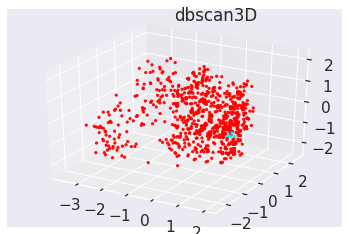

In [332]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.text2D(0.5, 0.95, 'dbscan3D', transform=ax.transAxes)
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], c = Y, alpha = 0.9, s = 5)
plt.savefig(Filepath+str(my_minpts)+"_"+str(my_eps)+"_"+"DBSCAN3D_out.png")
plt.show()


Testing with sklearn

In [333]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import StandardScaler

In [334]:
reduced_rate =0.5
from sklearn.decomposition.incremental_pca import IncrementalPCA
ncomponents = int(X_train.shape[1] * reduced_rate)
pca = IncrementalPCA(n_components = ncomponents)
X_train = pca.fit_transform(X_train) 

In [335]:
db = DBSCAN(eps=my_eps, min_samples=my_minpts).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#print(labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 748


[(0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0), (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)]


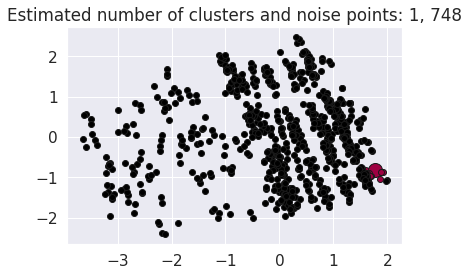

In [336]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
#print(unique_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 10, len(unique_labels))]
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    #print(xy)
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters and noise points: %d, %d' % (n_clusters_ ,n_noise_))
plt.savefig(Filepath+str(my_minpts)+"_"+str(my_eps)+"_"+"DBSCAN2D_out.png")
plt.show()

Optics

In [427]:
 import json
 import numpy as np
 def load_feature_vectors():
        data = []
        lengths = []
        
        with open(Filepath+"miner.tmp.non_redundant_rules", 'r') as feature_reader:
            print('Loading number of LHS and RHS features...')
            lhs_count = int(feature_reader.readline())
            rhs_count = int(feature_reader.readline())
            print('Loading feature vectors... ')
            for line in feature_reader:
                rule_text, f_vector = json.loads(line.strip())
                rule = string_2_rule(rule_text.strip())
                lengths.append(rule.length())
                #print(rule) this rule as an object of the assocition rule class
                data.append(f_vector)
                
                
        return np.array(data), lengths, lhs_count, rhs_count

In [428]:
X_train, lengths, lhs_feature_count, rhs_feature_count = load_feature_vectors() #step 1

Loading number of LHS and RHS features...
Loading feature vectors... 


In [429]:
lhs_feature_count,rhs_feature_count

(42, 2)

Loading Association Rules

In [430]:
def load_association_rules():
        association_rules_list = []
        with open(Filepath+"miner.tmp.non_redundant_rules", 'r') as rules_reader:
            rules_reader.readline()
            rules_reader.readline()
            
            for line in rules_reader:
                rule_text, _ = json.loads(line.strip())
                association_rules_list.append(AssociationRule.string_2_rule(rule_text.strip()))
        print(association_rules_list)
        return association_rules_list

In [431]:
association_rules_list = load_association_rules() #step 2

[<__main__.AssociationRule object at 0x7f95605dbcc0>, <__main__.AssociationRule object at 0x7f95605db240>, <__main__.AssociationRule object at 0x7f95605dbd30>, <__main__.AssociationRule object at 0x7f95605dbe80>, <__main__.AssociationRule object at 0x7f95605dbeb8>, <__main__.AssociationRule object at 0x7f95605db860>, <__main__.AssociationRule object at 0x7f95605db3c8>, <__main__.AssociationRule object at 0x7f95605db6d8>, <__main__.AssociationRule object at 0x7f95605dbcf8>, <__main__.AssociationRule object at 0x7f95605db710>, <__main__.AssociationRule object at 0x7f95605db898>, <__main__.AssociationRule object at 0x7f95605db940>, <__main__.AssociationRule object at 0x7f95605dbb00>, <__main__.AssociationRule object at 0x7f95605dbda0>, <__main__.AssociationRule object at 0x7f95605dbb38>, <__main__.AssociationRule object at 0x7f95605db748>, <__main__.AssociationRule object at 0x7f95605db5f8>, <__main__.AssociationRule object at 0x7f954eb9d160>, <__main__.AssociationRule object at 0x7f954eb

In [432]:
freq_itemset_dict = load_frequent_itemsets_as_dict()

In [433]:
from sklearn.decomposition.incremental_pca import IncrementalPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [434]:
def run_dbscan(dbscan_params, nthreads, data, points,xi):
        print ('Doing clustering ....')
        print('epsilon ' + str(epsilon))
        reduced_rate =0.5
        
        ncomponents = int(data.shape[1] * reduced_rate)
        pca = IncrementalPCA(n_components = ncomponents)
        data = pca.fit_transform(data) 
        
        
        db  = OPTICS(min_samples=points,xi=xi).fit(data)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        
        labels = db.labels_
        
        #Y = noconflict_db.Y.copy()

        Y = labels
        
        n_clusters = len(set(Y))- (1 if -1 in Y else 0)
        n_noises = list(Y).count(-1)
        
       
        print('Number of clusters' + str(n_clusters))
        print('Number of noises' + str(n_noises))
    
        print("Y" , Y)
        print("Type of Y is ",type(Y))
        print("Lenght of Y is",len(Y))
        return Y

In [435]:
def merge_itemsets(itemset_1, itemset_2):
    merged_items = []
    merged_items.extend(itemset_1)
    merged_items.extend(itemset_2)
    merged_items = list(set(merged_items))
    merged_items = sorted(merged_items)
    
    return merged_items

In [436]:
from collections import Counter

In [ ]:
cluster_labels = run_dbscan(dbscan_params, nthreads = 4, data=X_train, points=my_minpoints, xi=xi)

Computing confidence

In [438]:
rules_and_their_clusters = []

In [439]:
confidence_support_values = compute_confidence(association_rules_list)

Saving to file

In [440]:
print('Saving clusters to the output file ....')
for i in range(len(cluster_labels)):
  rule_key = association_rules_list[i].serialize()
  rules_and_their_clusters.append((rule_key, cluster_labels[i], 
                                         confidence_support_values[rule_key]))

Saving clusters to the output file ....


In [441]:
rules_and_their_clusters = sorted(rules_and_their_clusters, key=lambda x: x[1])

In [442]:
with open('rules_with_clusters_Optics.txt', 'w') as f:
  f.write("\n".join(str(v) for v in rules_and_their_clusters))

Finding Unexpected rules

In [443]:
print('Finding unexpected patterns ....')

Finding unexpected patterns ....


In [444]:
unexpected_rules = clustering_engine.detect_unexpectedness(cluster_labels)

Geting conflict information...
761 2
Finding unexpectedness....
Number of unexpected patterns 23


In [445]:
with open('unexpected_rules_optics.txt', 'w') as f:
  f.write("\n".join(str(v) for v in unexpected_rules))

In [446]:
IOHelper.save_as_json_format('unexpected_rule_file_json_optics', unexpected_rules)

Plotting in 3D

In [447]:
import colorsys

def get_N_HexCol(N=5):

    HSV_tuples = [(x * 1.0 / N, 1, 1) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    #print(hex_out)
    return hex_out

In [451]:
def load_feature_vectors(input_file):
    features = []
    association_rules = []
    
    with open(input_file, 'r') as feature_reader:
        feature_reader.readline()
        feature_reader.readline()
        for line in feature_reader:
            rule_text, f_vector = json.loads(line.strip())
            association_rules.append(rule_text)
            features.append(f_vector)
    return np.array(features), association_rules

In [452]:
X, association_rules = load_feature_vectors(Filepath+"miner.tmp.non_redundant_rules")

In [453]:
m = 2
print('dimensional reduce: ' + str(m))
    
pca = IncrementalPCA(n_components = X.shape[1]//m)
new_X = pca.fit_transform(X)
clusters, number_of_clusters = load_clusters(Filepath+"rules_with_clusters_Optics.txt")
print (number_of_clusters)
    
unique_colors = get_N_HexCol(number_of_clusters + 1)
Y = []
for rule in association_rules:
  cluster_id = clusters[rule]
  Y.append(unique_colors[cluster_id + 1])

dimensional reduce: 2
1


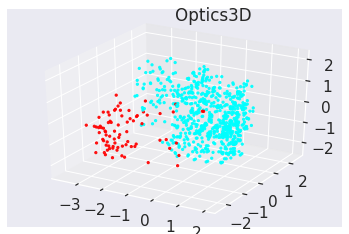

In [454]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.text2D(0.5, 0.95, 'Optics3D', transform=ax.transAxes)
ax.scatter(new_X[:,0], new_X[:,1], new_X[:,2], c = Y, alpha = 0.9, s = 5)
plt.savefig(Filepath+str(my_minpoints)+"_"+str(xi)+"_"+"Optics3D_out.png")
plt.show()


Evalution

In [455]:
#Loading test and train dataset

In [456]:
from sklearn.metrics.ranking import roc_curve, auc
from sklearn.metrics.classification import f1_score
from sklearn.svm.classes import SVC
from sklearn.ensemble.forest import RandomForestClassifier

In [457]:
train_data_set.load(inputfilepath, 0, has_header = False)

loading done


In [458]:
X_train, Y_train = train_data_set.convert_2_binary_format()

convert_2_binary_format attr_dict {'a4@0-2': True, 'a7@left': True, 'a3@30-34': True, 'a9@no': True, 'a1@30-39': True, 'a2@premeno': True, 'a6@3': True, 'a8@left_low': True, 'a5@no': True, 'a6@2': True, 'a7@right': True, 'a3@20-24': True, 'a8@right_up': True, 'a1@40-49': True, 'a1@60-69': True, 'a3@15-19': True, 'a2@ge40': True, 'a8@left_up': True, 'a8@right_low': True, 'a3@0-4': True, 'a3@25-29': True, 'a1@50-59': True, 'a3@50-54': True, 'a8@central': True, 'a3@10-14': True, 'a2@lt40': True, 'a6@1': True, 'a3@40-44': True, 'a3@35-39': True, 'a1@70-79': True, 'a3@5-9': True, 'a4@6-8': True, 'a9@yes': True, 'a5@yes': True, 'a4@9-11': True, 'a4@3-5': True, 'a3@45-49': True, 'a5@?': True, 'a4@15-17': True, 'a4@12-14': True, 'a8@?': True, 'a4@24-26': True}
classes_list ['class@no', 'class@yes']
classes_dict {'class@no': 0, 'class@yes': 1}
attr_dict {'a1@30-39': 0, 'a1@40-49': 1, 'a1@50-59': 2, 'a1@60-69': 3, 'a1@70-79': 4, 'a2@ge40': 5, 'a2@lt40': 6, 'a2@premeno': 7, 'a3@0-4': 8, 'a3@10-14

In [459]:
Y_train.item_dict

{'class@no': 0, 'class@yes': 1}

In [460]:
test_data_set = DataSet()
test_data_set.load(inputTestfilepath, 0, has_header = False)
Xtest, Ytest = test_data_set.convert_2_binary_format_with(X_train.item_dict, Y_train.item_dict)
Ytest = Ytest.flatten()

loading done
not in features...


In [461]:
class_count = train_data_set.number_of_classes()

In [462]:
class_count

2

DBSCAN

In [463]:
unexpected_rules = IOHelper.load_json_object(Filepath+"unexpected_rule_file_json_DBSCAN")

In [464]:
def filter_association_rules(unexpected_rules, delta_1 = 0):
    rules = []
    for x in unexpected_rules:
        if x[2][0][1] > delta_1: 
            rules.append(AssociationRule.string_2_rule(x[0]))
    return rules

In [465]:
refined_unexpected_rules = filter_association_rules(unexpected_rules)

In [466]:
print('svm testing...')
svc_model = SVC()
svc_model.fit(X_train.relation_matrix, Y_train.values.flatten())

svm testing...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [467]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def refine_with_unexpectedness(data_set, classes_dict, preY, Ytrue, unexpected_rules, model, clus):
    
    print('Refine with unexpected rules...')
    y_pred = np.copy(preY)
    for i in range(data_set.size()):
        x = data_set.get_transaction(i)
        print("x is ",x)
        for r in unexpected_rules:
            #print(r)
            if r.satisfy_rule(x, is_lhs = True):
                print("r.satisfy_rule(x, is_lhs = True)", r.satisfy_rule(x, is_lhs = True))
                label = r.right_items[0]
                print("label is ",label)
                y_pred[i] = classes_dict[label]
                print("y pred for i is",y_pred[i])
    x_axis_labels = ['No', 'Yes']
    y_axis_labels = ['No', 'Yes']
    print(f1_score(Ytrue, y_pred, average=None))
    print(confusion_matrix(Ytrue, y_pred))
    c=confusion_matrix(Ytrue, y_pred)
    df_cm = pd.DataFrame(c, range(2), range(2))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

    
    if (data_set.number_of_classes() <= 2):
        fpr, tpr, _ = roc_curve(Ytrue, y_pred.flatten())
        print(auc(fpr, tpr))

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")  
    plt.savefig(Filepath+"Refined_"+model+"_"+"DBSCAN"+"_"+"confusion_matrix.png")
    plt.show()

In [468]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.87671233 0.52631579]
0.6785714285714286


Refine with unexpected rules...
x is  ['a4@0-2', 'a1@60-69', 'a7@left', 'a3@20-24', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_low', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a9@no', 'a2@ge40', 'a3@25-29', 'a8@left_up', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a3@40-44', 'a9@no', 'a2@ge40', 'a8@left_up', 'a1@50-59', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a9@no', 'a3@10-14', 'a1@50-59', 'a2@premeno', 'a6@3', 'a8@left_low', 'a5@no']
x is  ['a8@central', 'a4@0-2', 'a1@60-69', 'a7@left', 'a3@5-9', 'a9@no', 'a2@ge40', 'a6@1', 'a5@no']
x is  ['a4@0-2', 'a6@2', 'a7@left', 'a9@no', 'a3@10-14', 'a8@left_up', 'a1@40-49', 'a2@premeno', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a1@70-79', 'a3@20-24', 'a9@no', 'a2@ge40', 'a8@left_up', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a1@70-79', 'a3@40-44', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a3@15-19', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a8@central', 'a4@0-2', 

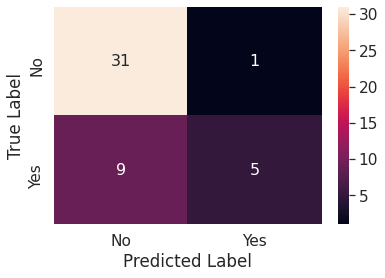

In [469]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, svc_y_pred, Ytest, refined_unexpected_rules, "SVM", "DBSCAN")

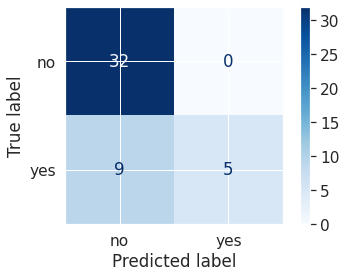

In [470]:
class_names = ['no', 'yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(svc_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.savefig(Filepath+"SVM"+"_"+"DBSCAN"+"_"+"confusion_matrix.png")
plt.show()

Random Forest

In [471]:
print('Random forest testing...')
rf_model = RandomForestClassifier(n_estimators=20, random_state=1)
rf_model.fit(X_train.relation_matrix, Y_train.values.flatten())
    
rf_y_pred = rf_model.predict(Xtest)
print(f1_score(Ytest, rf_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, rf_y_pred.flatten())
  print(auc(fpr, tpr))
    


Random forest testing...
[0.88571429 0.63636364]
0.734375


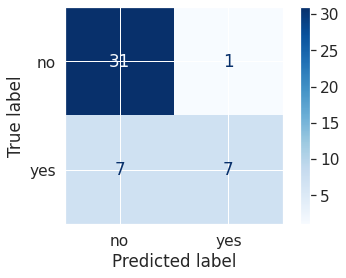

In [472]:
class_names = ['no', 'yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(rf_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.savefig(Filepath+"RF"+"_"+"DBSCAN"+"_"+"confusion_matrix.png")
plt.show()

Refine with unexpected rules...
x is  ['a4@0-2', 'a1@60-69', 'a7@left', 'a3@20-24', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_low', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a9@no', 'a2@ge40', 'a3@25-29', 'a8@left_up', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a3@40-44', 'a9@no', 'a2@ge40', 'a8@left_up', 'a1@50-59', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a9@no', 'a3@10-14', 'a1@50-59', 'a2@premeno', 'a6@3', 'a8@left_low', 'a5@no']
x is  ['a8@central', 'a4@0-2', 'a1@60-69', 'a7@left', 'a3@5-9', 'a9@no', 'a2@ge40', 'a6@1', 'a5@no']
x is  ['a4@0-2', 'a6@2', 'a7@left', 'a9@no', 'a3@10-14', 'a8@left_up', 'a1@40-49', 'a2@premeno', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a1@70-79', 'a3@20-24', 'a9@no', 'a2@ge40', 'a8@left_up', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a1@70-79', 'a3@40-44', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a3@15-19', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a8@central', 'a4@0-2', 

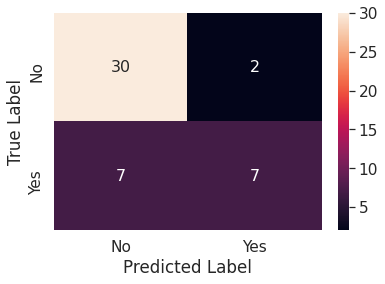

In [473]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, rf_y_pred, Ytest, refined_unexpected_rules, "RF", "DBSCAN")

MLP

In [474]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf_mlp.fit(X_train.relation_matrix, Y_train.values.flatten())
    
mlp_y_pred = clf_mlp.predict(Xtest)
print(f1_score(Ytest, mlp_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, mlp_y_pred.flatten())
  print(auc(fpr, tpr))

[0.87671233 0.52631579]
0.6785714285714286


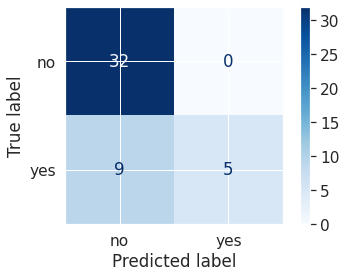

In [475]:
class_names = ['no', 'yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(clf_mlp, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.savefig(Filepath+"MLP"+"_"+"DBSCAN"+"_"+"confusion_matrix.png")
plt.show()

Refine with unexpected rules...
x is  ['a4@0-2', 'a1@60-69', 'a7@left', 'a3@20-24', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_low', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a9@no', 'a2@ge40', 'a3@25-29', 'a8@left_up', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a3@40-44', 'a9@no', 'a2@ge40', 'a8@left_up', 'a1@50-59', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a9@no', 'a3@10-14', 'a1@50-59', 'a2@premeno', 'a6@3', 'a8@left_low', 'a5@no']
x is  ['a8@central', 'a4@0-2', 'a1@60-69', 'a7@left', 'a3@5-9', 'a9@no', 'a2@ge40', 'a6@1', 'a5@no']
x is  ['a4@0-2', 'a6@2', 'a7@left', 'a9@no', 'a3@10-14', 'a8@left_up', 'a1@40-49', 'a2@premeno', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a1@70-79', 'a3@20-24', 'a9@no', 'a2@ge40', 'a8@left_up', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a1@70-79', 'a3@40-44', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a3@15-19', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a8@central', 'a4@0-2', 

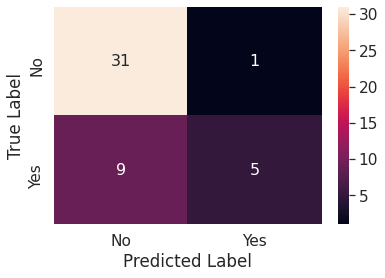

In [476]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, mlp_y_pred, Ytest, refined_unexpected_rules, "MLP", "DBSCAN")

Optics

In [493]:
unexpected_rules = IOHelper.load_json_object(Filepath+"unexpected_rule_file_json_optics")

In [494]:
refined_unexpected_rules = filter_association_rules(unexpected_rules)

In [495]:
print('svm testing...')
svc_model = SVC()
svc_model.fit(X_train.relation_matrix, Y_train.values.flatten())

svm testing...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [496]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def refine_with_unexpectedness(data_set, classes_dict, preY, Ytrue, unexpected_rules, model, clus):
    
    print('Refine with unexpected rules...')
    y_pred = np.copy(preY)
    for i in range(data_set.size()):
        x = data_set.get_transaction(i)
        print("x is ",x)
        for r in unexpected_rules:
            #print(r)
            if r.satisfy_rule(x, is_lhs = True):
                print("r.satisfy_rule(x, is_lhs = True)", r.satisfy_rule(x, is_lhs = True))
                label = r.right_items[0]
                print("label is ",label)
                y_pred[i] = classes_dict[label]
                print("y pred for i is",y_pred[i])
    x_axis_labels = ['No', 'Yes']
    y_axis_labels = ['No', 'Yes']
    print(f1_score(Ytrue, y_pred, average=None))
    print(confusion_matrix(Ytrue, y_pred))
    c=confusion_matrix(Ytrue, y_pred)
    df_cm = pd.DataFrame(c, range(2), range(2))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

    
    if (data_set.number_of_classes() <= 2):
        fpr, tpr, _ = roc_curve(Ytrue, y_pred.flatten())
        print(auc(fpr, tpr))

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")  
    plt.savefig(Filepath+"Refined_"+model+"_"+"Optics"+"_"+"confusion_matrix.png")
    plt.show()

In [497]:
svc_y_pred = svc_model.predict(Xtest)
print(f1_score(Ytest, svc_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, svc_y_pred.flatten())    
  print(auc(fpr, tpr))

[0.87671233 0.52631579]
0.6785714285714286


Refine with unexpected rules...
x is  ['a4@0-2', 'a1@60-69', 'a7@left', 'a3@20-24', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_low', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a9@no', 'a2@ge40', 'a3@25-29', 'a8@left_up', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a3@40-44', 'a9@no', 'a2@ge40', 'a8@left_up', 'a1@50-59', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a9@no', 'a3@10-14', 'a1@50-59', 'a2@premeno', 'a6@3', 'a8@left_low', 'a5@no']
x is  ['a8@central', 'a4@0-2', 'a1@60-69', 'a7@left', 'a3@5-9', 'a9@no', 'a2@ge40', 'a6@1', 'a5@no']
x is  ['a4@0-2', 'a6@2', 'a7@left', 'a9@no', 'a3@10-14', 'a8@left_up', 'a1@40-49', 'a2@premeno', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a1@70-79', 'a3@20-24', 'a9@no', 'a2@ge40', 'a8@left_up', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a1@70-79', 'a3@40-44', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a3@15-19', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a8@central', 'a4@0-2', 

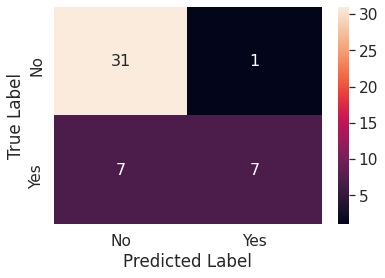

In [498]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, svc_y_pred, Ytest, refined_unexpected_rules, "SVM", "Optics")

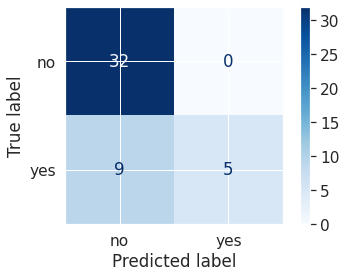

In [499]:
class_names = ['no', 'yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(svc_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.savefig(Filepath+"SVM"+"_"+"Optics"+"_"+"confusion_matrix.png")
plt.show()

Random Forest

In [500]:
print('Random forest testing...')
rf_model = RandomForestClassifier(n_estimators=20, random_state=1)
rf_model.fit(X_train.relation_matrix, Y_train.values.flatten())
    
rf_y_pred = rf_model.predict(Xtest)
print(f1_score(Ytest, rf_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, rf_y_pred.flatten())
  print(auc(fpr, tpr))
    


Random forest testing...
[0.88571429 0.63636364]
0.734375


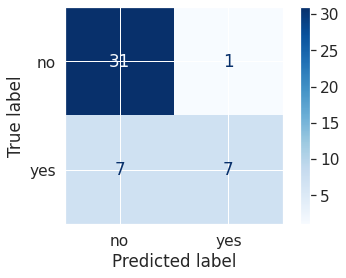

In [501]:
class_names = ['no', 'yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(rf_model, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.savefig(Filepath+"RF"+"_"+"Optics"+"_"+"confusion_matrix.png")
plt.show()

Refine with unexpected rules...
x is  ['a4@0-2', 'a1@60-69', 'a7@left', 'a3@20-24', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_low', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a9@no', 'a2@ge40', 'a3@25-29', 'a8@left_up', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a3@40-44', 'a9@no', 'a2@ge40', 'a8@left_up', 'a1@50-59', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a9@no', 'a3@10-14', 'a1@50-59', 'a2@premeno', 'a6@3', 'a8@left_low', 'a5@no']
x is  ['a8@central', 'a4@0-2', 'a1@60-69', 'a7@left', 'a3@5-9', 'a9@no', 'a2@ge40', 'a6@1', 'a5@no']
x is  ['a4@0-2', 'a6@2', 'a7@left', 'a9@no', 'a3@10-14', 'a8@left_up', 'a1@40-49', 'a2@premeno', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a1@70-79', 'a3@20-24', 'a9@no', 'a2@ge40', 'a8@left_up', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a1@70-79', 'a3@40-44', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a3@15-19', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a8@central', 'a4@0-2', 

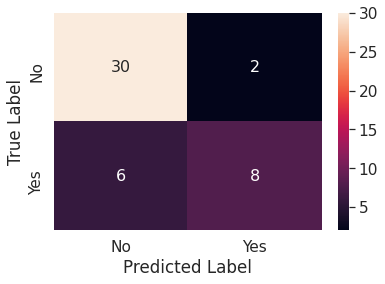

In [502]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, rf_y_pred, Ytest, refined_unexpected_rules, "RF", "Optics")

MLP

In [503]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf_mlp.fit(X_train.relation_matrix, Y_train.values.flatten())
    
mlp_y_pred = clf_mlp.predict(Xtest)
print(f1_score(Ytest, mlp_y_pred, average=None))
if (class_count <= 2):
  fpr, tpr, _ = roc_curve(Ytest, mlp_y_pred.flatten())
  print(auc(fpr, tpr))

[0.87671233 0.52631579]
0.6785714285714286


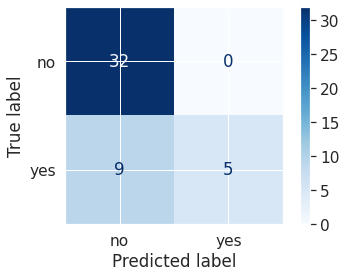

In [504]:
class_names = ['no', 'yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(clf_mlp, Xtest, Ytest,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 )
plt.savefig(Filepath+"MLP"+"_"+"Optics"+"_"+"confusion_matrix.png")
plt.show()

Refine with unexpected rules...
x is  ['a4@0-2', 'a1@60-69', 'a7@left', 'a3@20-24', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_low', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a9@no', 'a2@ge40', 'a3@25-29', 'a8@left_up', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a3@40-44', 'a9@no', 'a2@ge40', 'a8@left_up', 'a1@50-59', 'a7@right', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a9@no', 'a3@10-14', 'a1@50-59', 'a2@premeno', 'a6@3', 'a8@left_low', 'a5@no']
x is  ['a8@central', 'a4@0-2', 'a1@60-69', 'a7@left', 'a3@5-9', 'a9@no', 'a2@ge40', 'a6@1', 'a5@no']
x is  ['a4@0-2', 'a6@2', 'a7@left', 'a9@no', 'a3@10-14', 'a8@left_up', 'a1@40-49', 'a2@premeno', 'a5@no']
x is  ['a4@0-2', 'a7@left', 'a1@70-79', 'a3@20-24', 'a9@no', 'a2@ge40', 'a8@left_up', 'a6@3', 'a5@no']
x is  ['a4@0-2', 'a1@70-79', 'a3@40-44', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a4@0-2', 'a1@60-69', 'a3@15-19', 'a9@no', 'a2@ge40', 'a6@1', 'a8@left_up', 'a7@right', 'a5@no']
x is  ['a8@central', 'a4@0-2', 

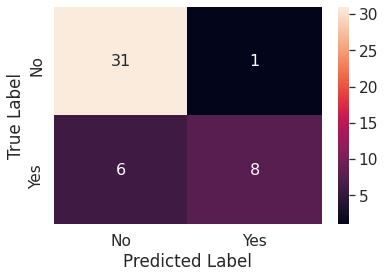

In [505]:
refine_with_unexpectedness(test_data_set, Y_train.item_dict, mlp_y_pred, Ytest, refined_unexpected_rules, "MLP", "Optics")

Test data ratio

In [506]:
unique, counts = np.unique(Y_train.values, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 169]
 [  1  71]]


In [507]:
Ytest

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [508]:
unique, counts = np.unique(Ytest, return_counts=True)

print(np.asarray((unique, counts)).T)

[[ 0 32]
 [ 1 14]]
